<a href="https://colab.research.google.com/github/hrootscraft/media_campaign_expense/blob/main/MediaCampaignCostPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Food Mart (CFM) is a chain of convenience stores in the United States. The private company's headquarters are located in Mentor, Ohio, and currently, approximately 325 stores are located in the US. Convenient Food Mart operates on the franchise system.

Food Mart was the nation's third-largest chain of convenience stores as of 1988.
The NASDAQ exchange dropped Convenient Food Mart the same year when the company failed to meet financial reporting requirements. Carden & Cherry advertised Convenient Food Mart with the Ernest character in the 1980s.

Devise a Machine Learning Model that helps predict the cost of media campaigns in the food marts on the basis of the features provided.

Here, the focus would be on developing a stacking ensemble of models.

# Setup Dependencies

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gauravduttakiit/media-campaign-cost-prediction

  0% 0.00/765k [00:00<?, ?B/s]
100% 765k/765k [00:00<00:00, 124MB/s]


In [2]:
!unzip media-campaign-cost-prediction.zip -d data

Archive:  media-campaign-cost-prediction.zip
  inflating: data/test_dataset.csv   
  inflating: data/train_dataset.csv  


# Basic Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

# Features Description

Store related information

- store_sales(in millions)
- unit_sales(in millions) : sales for that unit in millions
- units_per_case : units of item per case available in each store
- store_sqft : store area
- coffee_bar : if coffee bar is available in the store
- video_store : if video/gaming store is available
- salad_bar : if salad bar is available in the store
- prepared_food : is prepared food available in the store
- floris : are flower shelves available in the store

Item related information

- gross_weight : of an item
- recyclable_package : if the item is a recyclable_package
- low_fat : if the item is low_fat

Customer Related Information

- total_children
- avg_cars_at home(approx).1
- num_children_at_home
- Cost : cost on acquiring customers (in milions)


# Load data for cursory analysis

In [94]:
PATH_TRAIN = './data/train_dataset.csv'
PATH_TEST = './data/test_dataset.csv'

In [95]:
def read_csv_idx(path):
  return pd.read_csv(path)

In [96]:
traindf=read_csv_idx(PATH_TRAIN)
testdf=read_csv_idx(PATH_TEST)

In [ ]:
traindf

store_sales(in millions)  unit_sales(in millions)  total_children  \
0                          2.68                      2.0             1.0   
1                          5.73                      3.0             5.0   
2                          2.62                      2.0             1.0   
3                         11.73                      3.0             1.0   
4                          4.82                      2.0             1.0   
...                         ...                      ...             ...   
51358                      3.70                      2.0             4.0   
51359                     10.36                      4.0             2.0   
51360                     11.19                      3.0             3.0   
51361                      3.78                      3.0             1.0   
51362                      2.91                      3.0             1.0   

       num_children_at_home  avg_cars_at home(approx).1  gross_weight  \
0                       0.0                         2.0          6.30   
1                       5.0                         3.0         18.70   
2                       1.0                         1.0          9.21   
3                       1.0                         3.0         10.90   
4                       1.0                         3.0          8.15   
...                     ...                         ...           ...   
51358                   4.0                         1.0         10.40   
51359                   0.0                         2.0          9.43   
51360                   0.0                         3.0         18.50   
51361                   1.0                         2.0         19.80   
51362                   0.0                         4.0          9.80   

       recyclable_package  low_fat  units_per_case  store_sqft  coffee_bar  \
0                     1.0      0.0            22.0     30584.0         1.0   
1                     1.0      0.0            30.0     20319.0         0.0   
2                     0.0      0.0             9.0     20319.0         0.0   
3                     1.0      1.0            15.0     23112.0         1.0   
4                     0.0      0.0             7.0     38382.0         0.0   
...                   ...      ...             ...         ...         ...   
51358                 1.0      1.0            18.0     34452.0         1.0   
51359                 0.0      0.0            20.0     30797.0         1.0   
51360                 0.0      0.0             5.0     30797.0         1.0   
51361                 0.0      1.0             8.0     23598.0         0.0   
51362                 1.0      0.0            18.0     39696.0         0.0   

       video_store  salad_bar  prepared_food  florist    cost  
0              1.0        1.0            1.0      1.0   79.59  
1              0.0        0.0            0.0      0.0  118.36  
2              0.0        0.0            0.0      0.0   67.20  
3              1.0        1.0            1.0      1.0   60.87  
4              0.0        0.0            0.0      0.0   86.79  
...            ...        ...            ...      ...     ...  
51358          0.0        0.0            0.0      1.0  147.17  
51359          1.0        1.0            1.0      1.0   92.57  
51360          1.0        1.0            1.0      1.0   92.57  
51361          0.0        0.0            0.0      1.0  135.92  
51362          0.0        1.0            1.0      0.0  129.50  

[51363 rows x 16 columns]

In [ ]:
print(traindf.columns)
print(testdf.columns)

Index(['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist',
       'cost'],
      dtype='object')
Index(['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist'],
      dtype='object')


In [97]:
def fix_col_names(df):
    """Removes (in millions) and (approx).1 from names of columns."""
    df.columns = df.columns.str.replace('(in millions)', '', regex=False)
    df.columns = df.columns.str.replace(' home(approx).1', '_home', regex=False)
    return df

traindf = fix_col_names(traindf)
testdf = fix_col_names(testdf)

In [ ]:
# Now traindf.columns should have the modified column names
print("train columns:", traindf.columns)
print("test columns:", testdf.columns)

train columns: Index(['store_sales', 'unit_sales', 'total_children', 'num_children_at_home',
       'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat',
       'units_per_case', 'store_sqft', 'coffee_bar', 'video_store',
       'salad_bar', 'prepared_food', 'florist', 'cost'],
      dtype='object')
test columns: Index(['store_sales', 'unit_sales', 'total_children', 'num_children_at_home',
       'avg_cars_at_home', 'gross_weight', 'recyclable_package', 'low_fat',
       'units_per_case', 'store_sqft', 'coffee_bar', 'video_store',
       'salad_bar', 'prepared_food', 'florist'],
      dtype='object')


In [98]:
# init some constants
target='cost'
input_fts = testdf.columns
arr = [("Train", traindf), ("Test", testdf)]

# EDA with auto eda library - dataprep

In [ ]:
!pip3 install dataprep

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 79.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.3 MB/s eta 0:00:00
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.24-cp310-cp310-linux_x86_64.whl size=1252693 sha256=49c3f4b3f

DataPrep Report
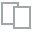
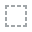
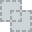
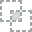
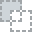
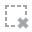
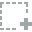
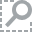
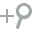
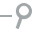
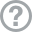
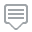
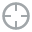
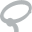
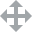
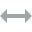
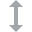
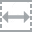
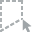
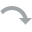
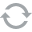
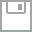
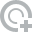
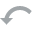
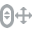
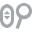
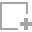
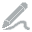
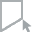
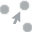
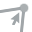
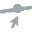

In [ ]:
from dataprep.eda import create_report
create_report(traindf)

# Auto EDA with SweetViz
<sub> for comparative eda of train and test datasets  </sub>

In [ ]:
!pip3 install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 39.1 MB/s eta 0:00:00


In [ ]:
import sweetviz as sv
compare_report = sv.compare([traindf, "train"], [testdf, "test"], target)
# compare_report.show_html('compare_report.html', open_browser=False)

                                             |          | [  0%]   00:00 -> (? left)


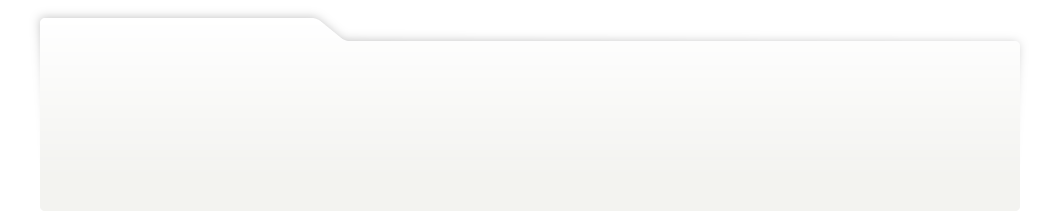
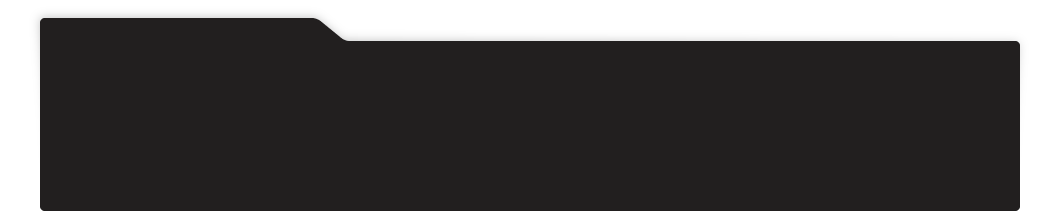
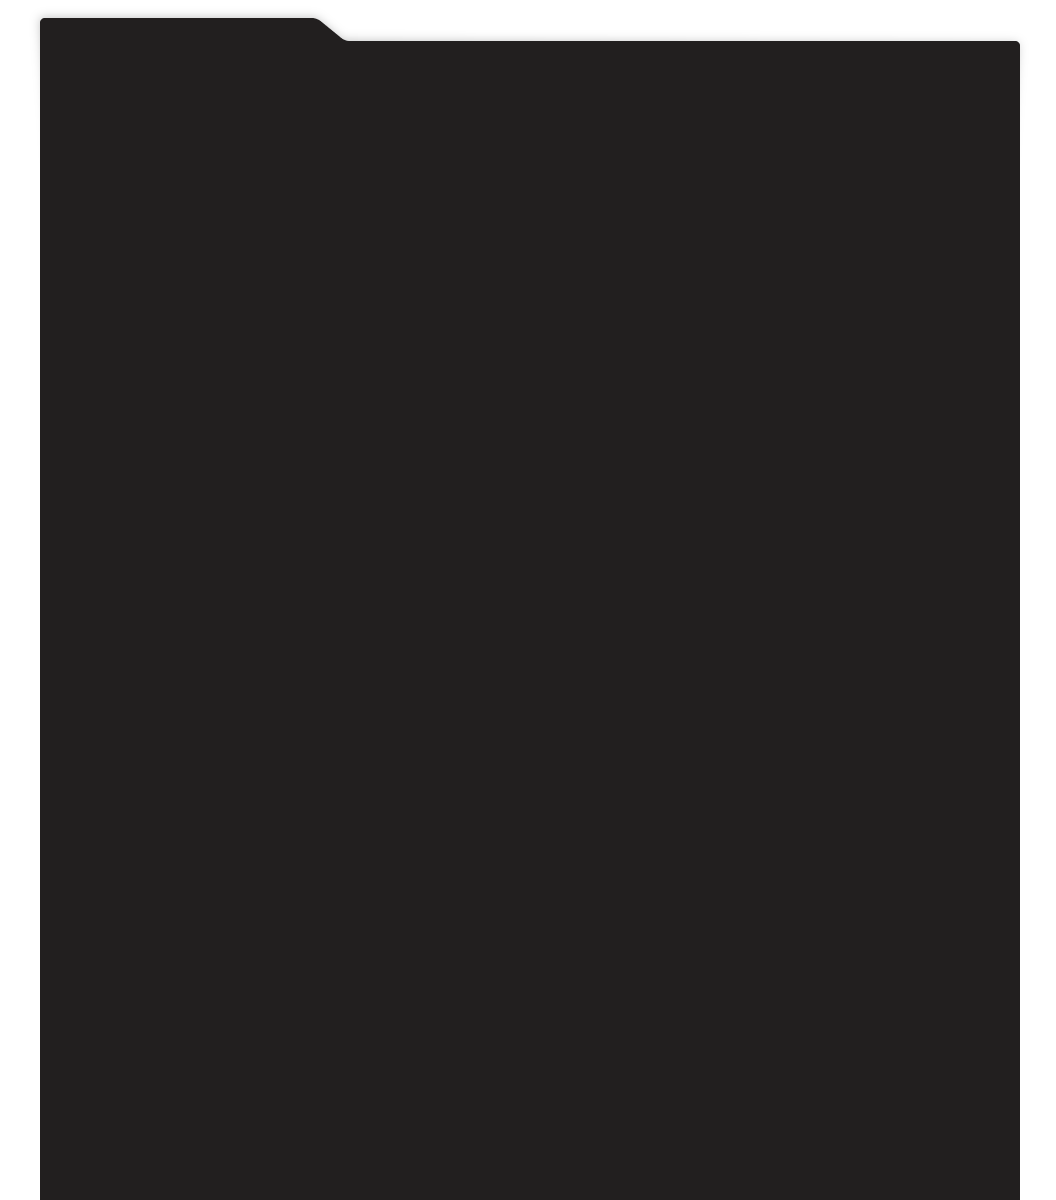
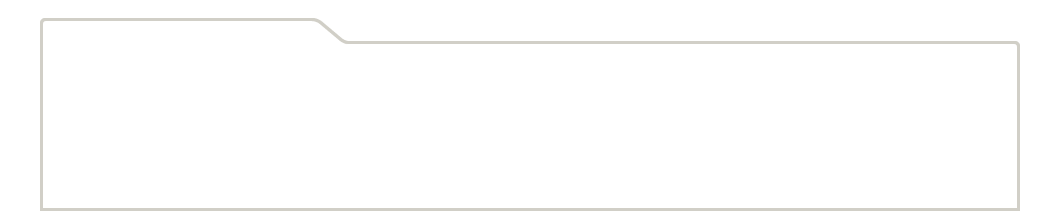
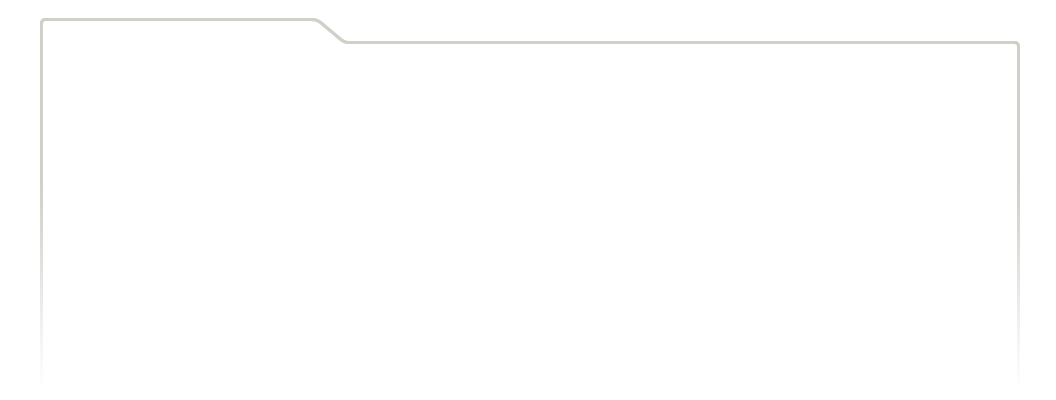
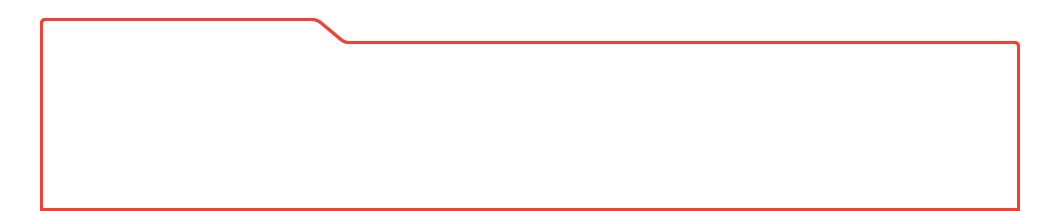
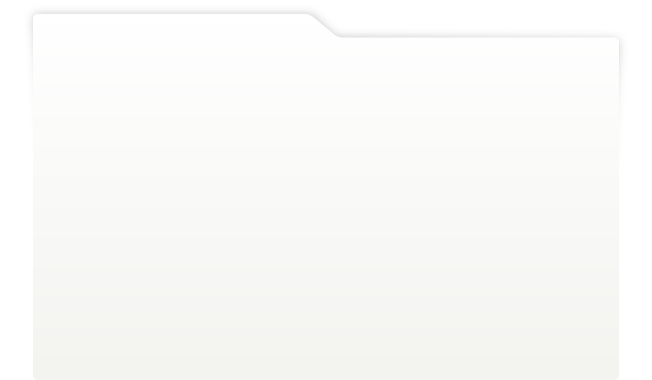
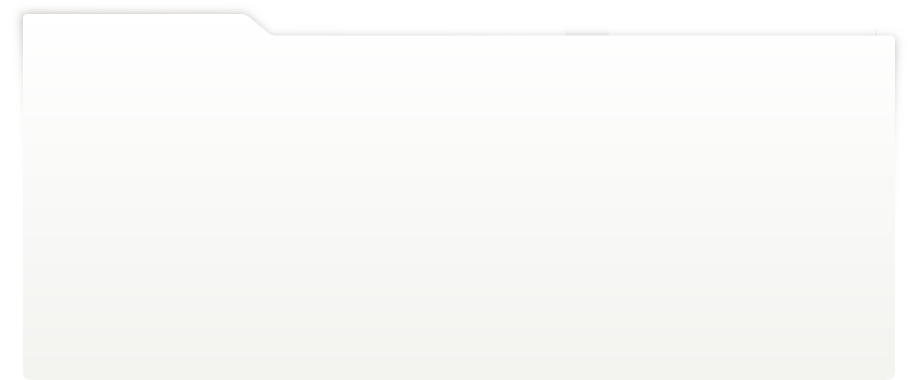
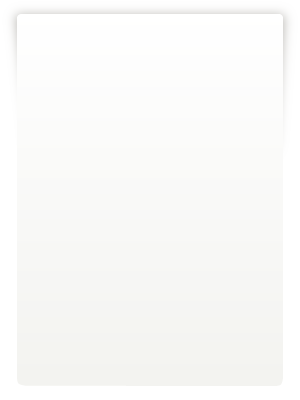
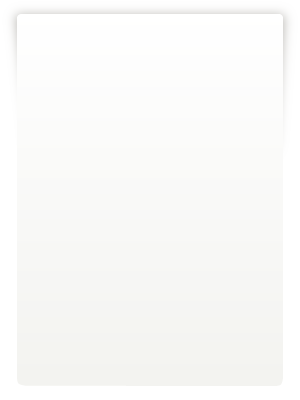
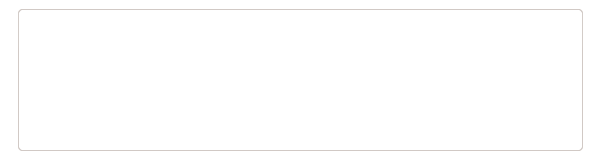
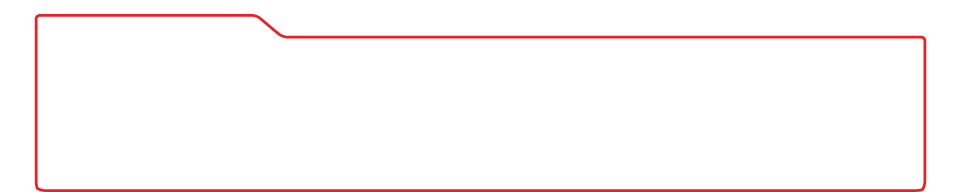
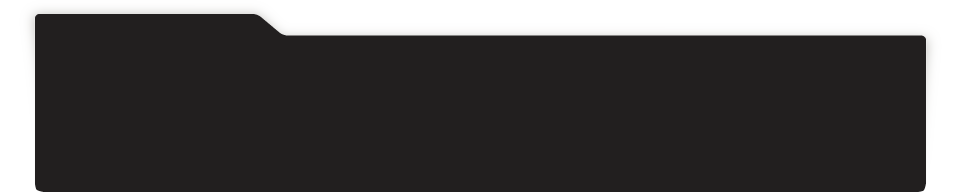
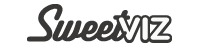
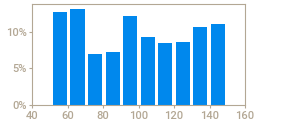
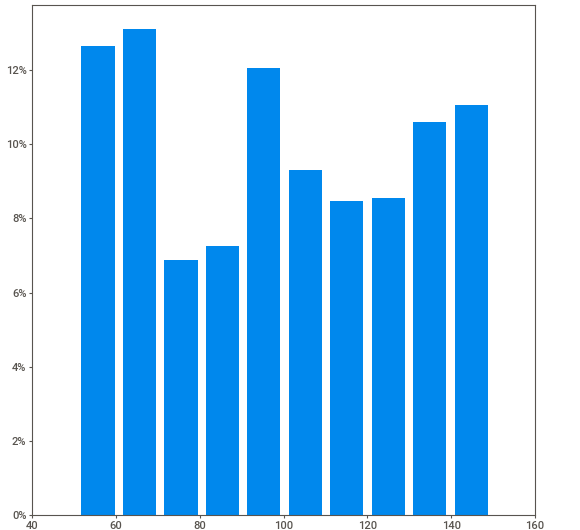
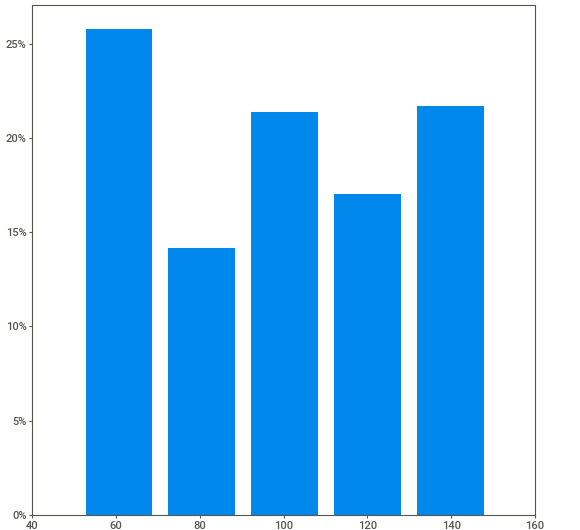
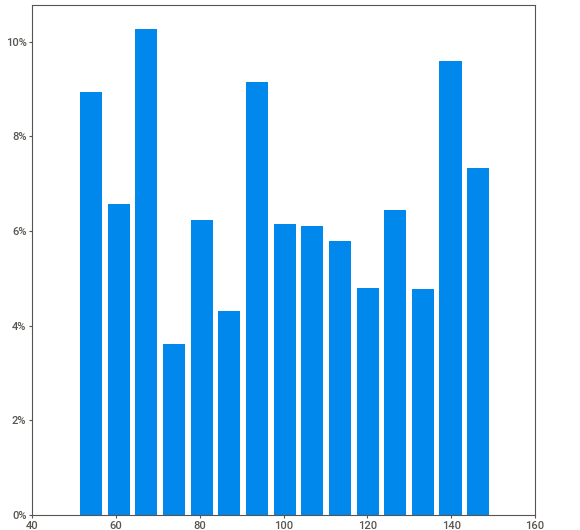
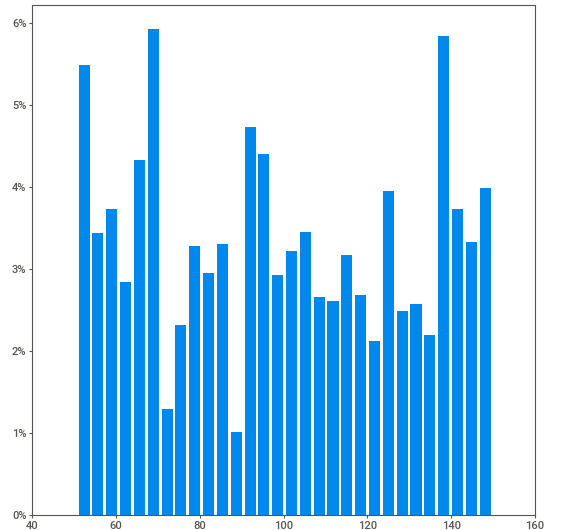
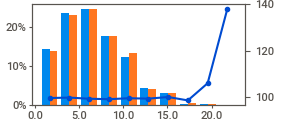
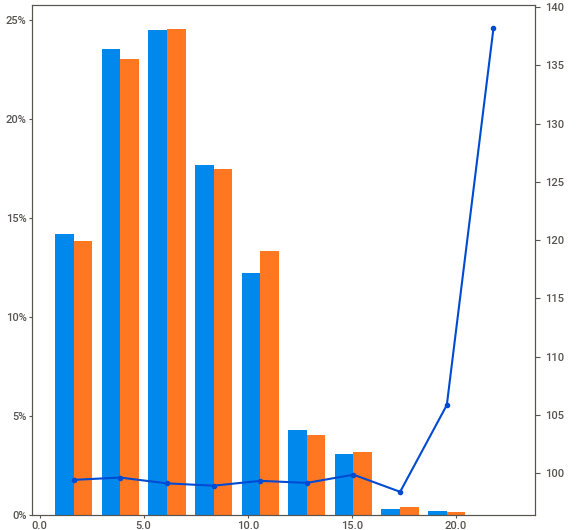
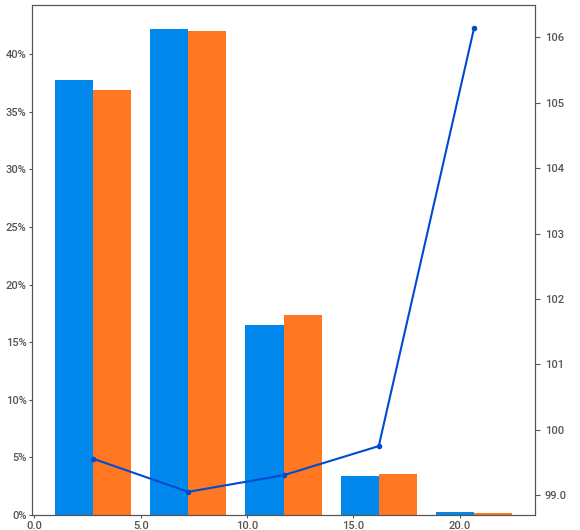
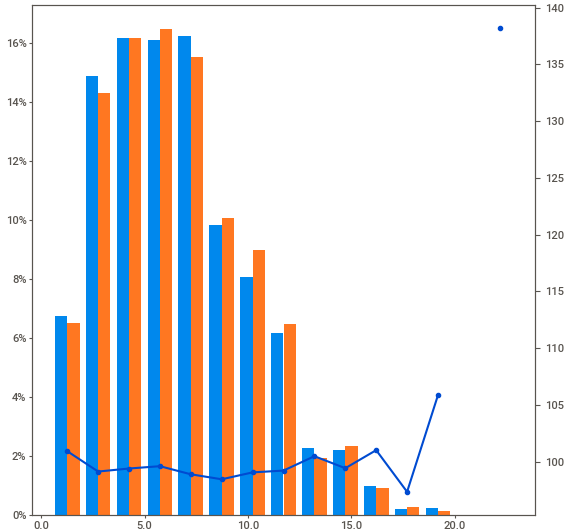
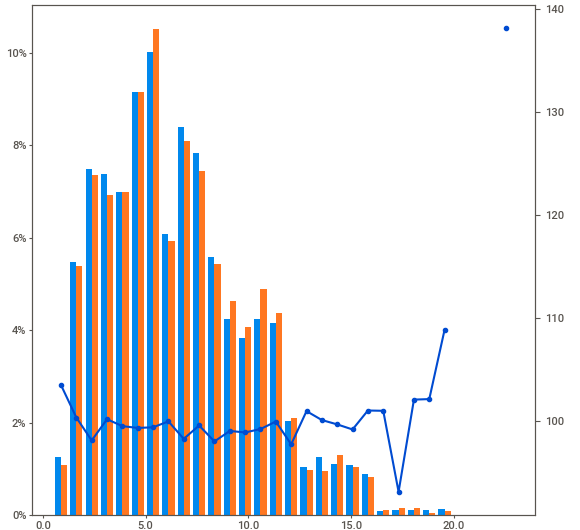
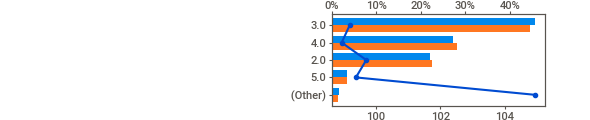
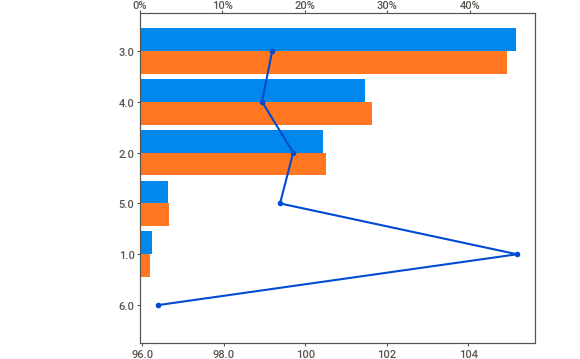
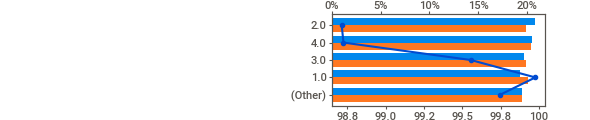
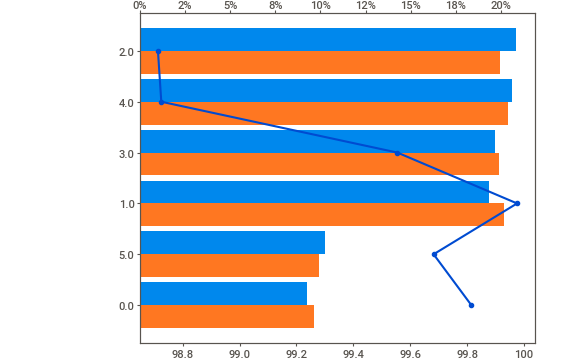
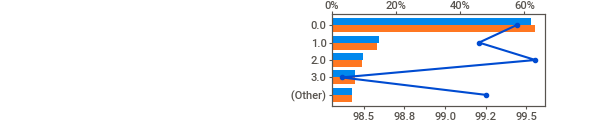
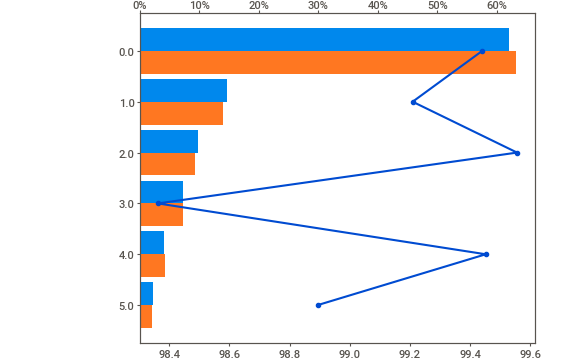
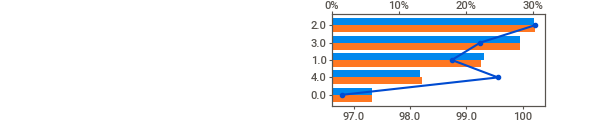
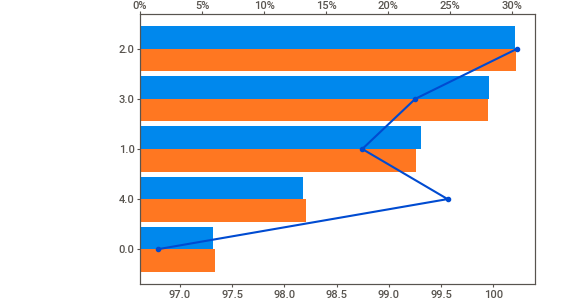
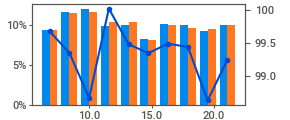
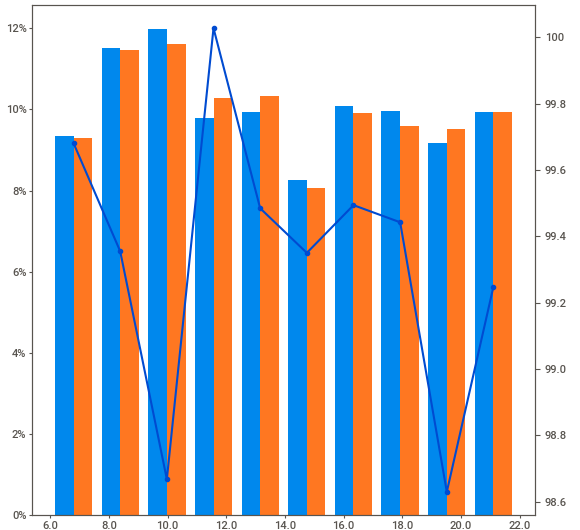
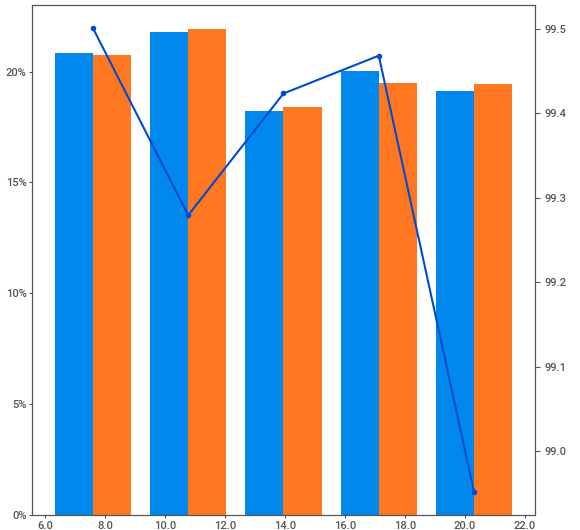
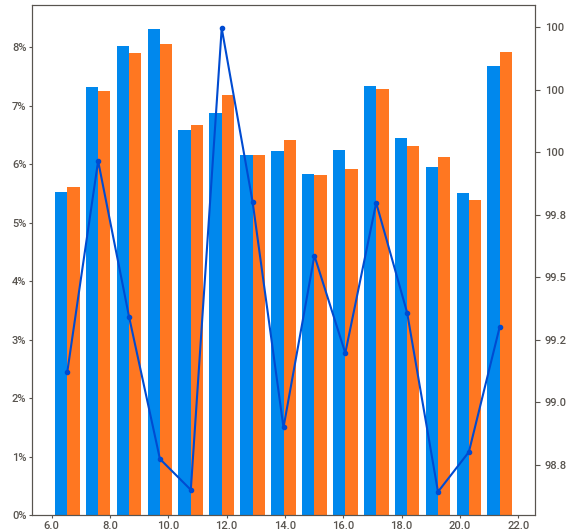
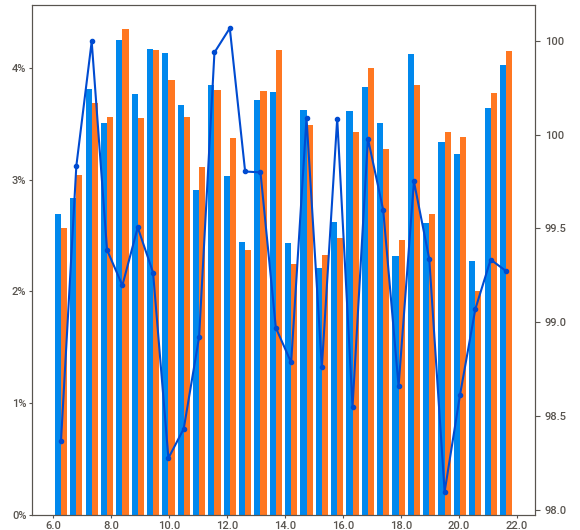
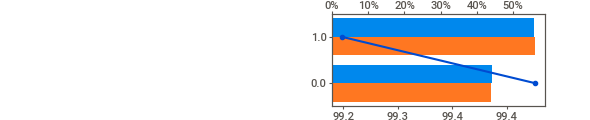
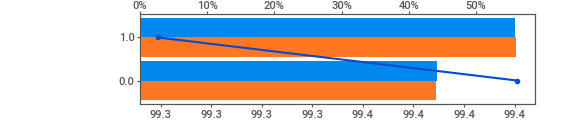
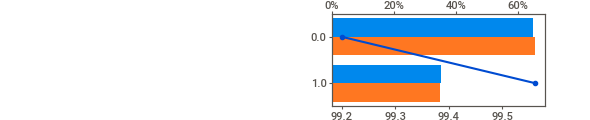
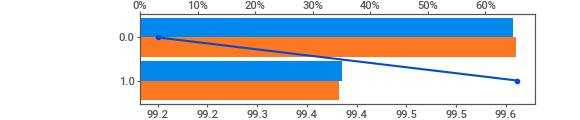
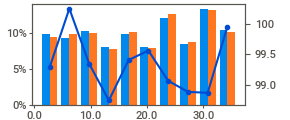
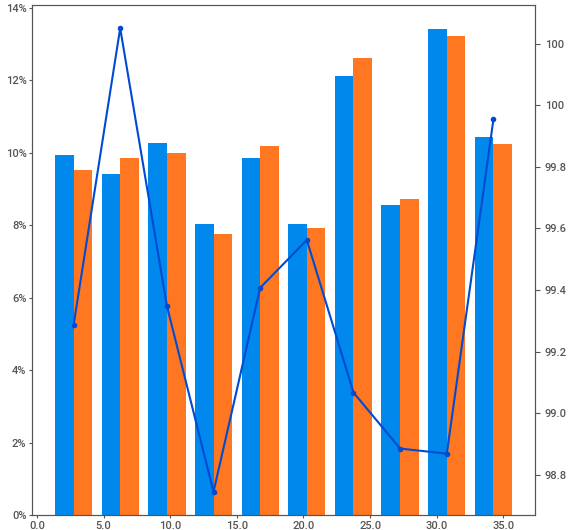
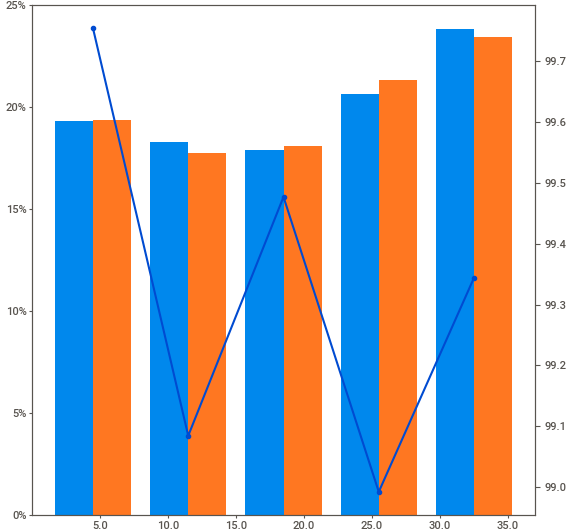
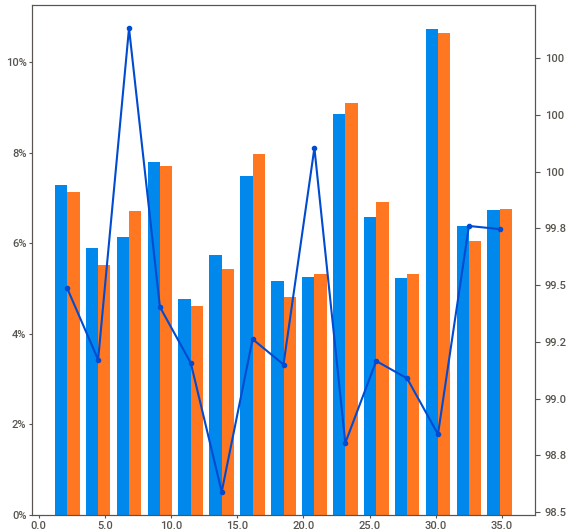
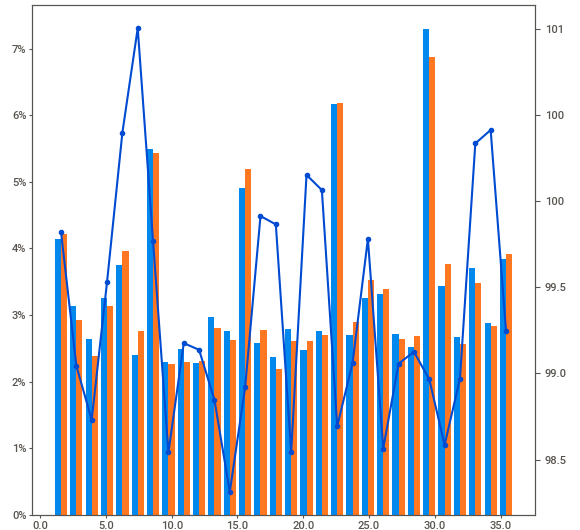
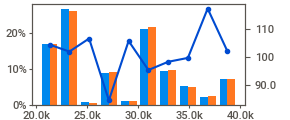
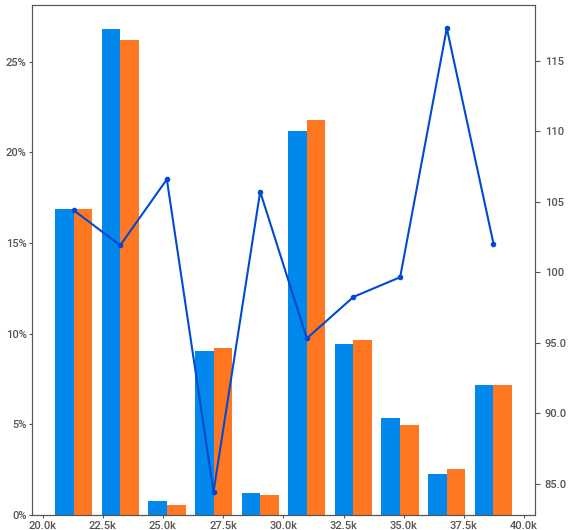
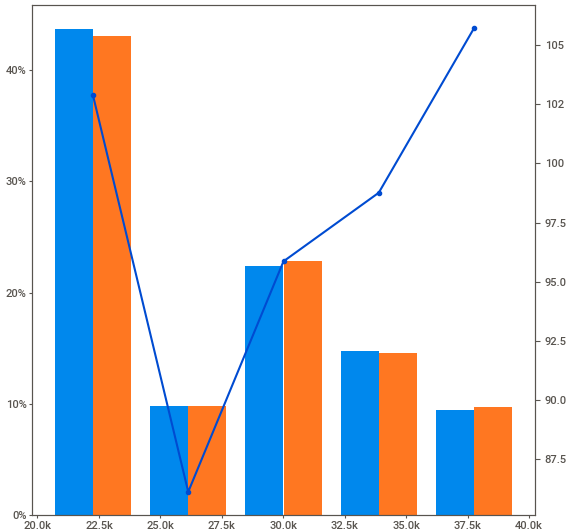
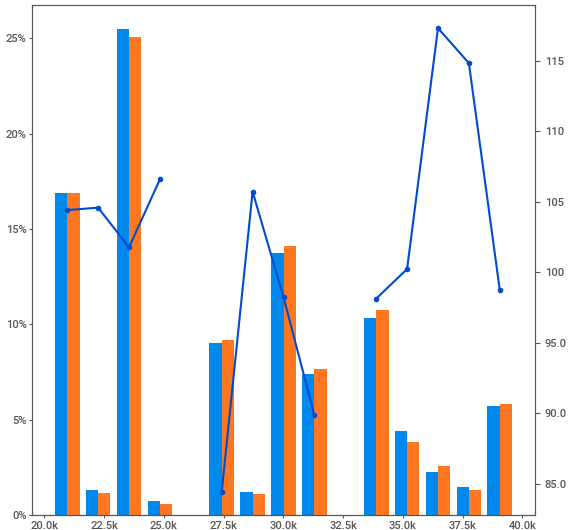
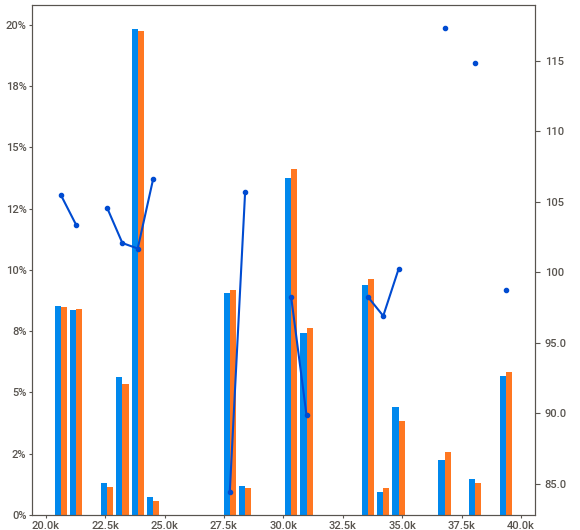
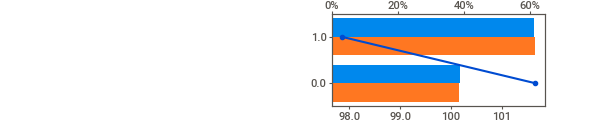
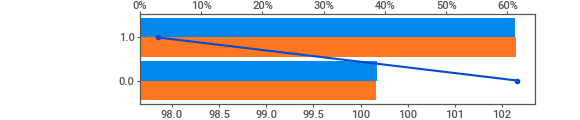
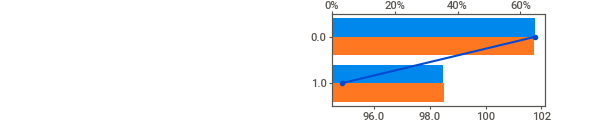
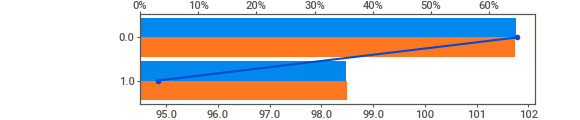
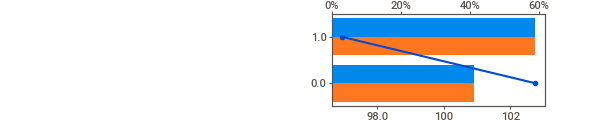
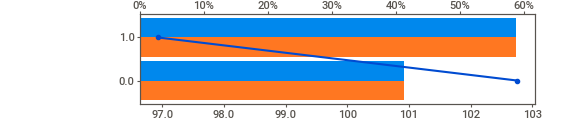
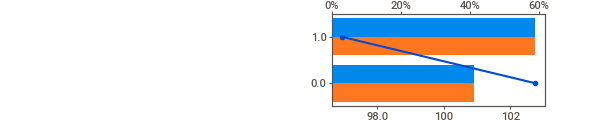
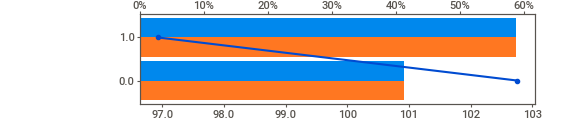
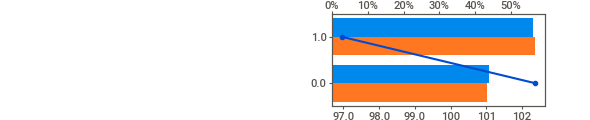
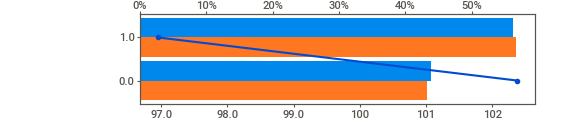
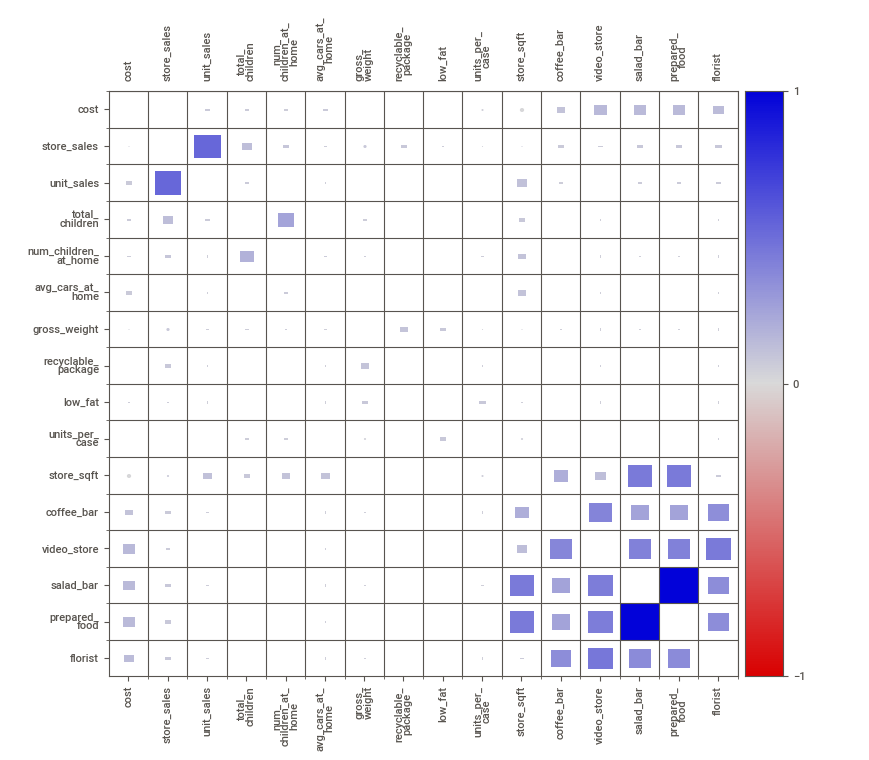
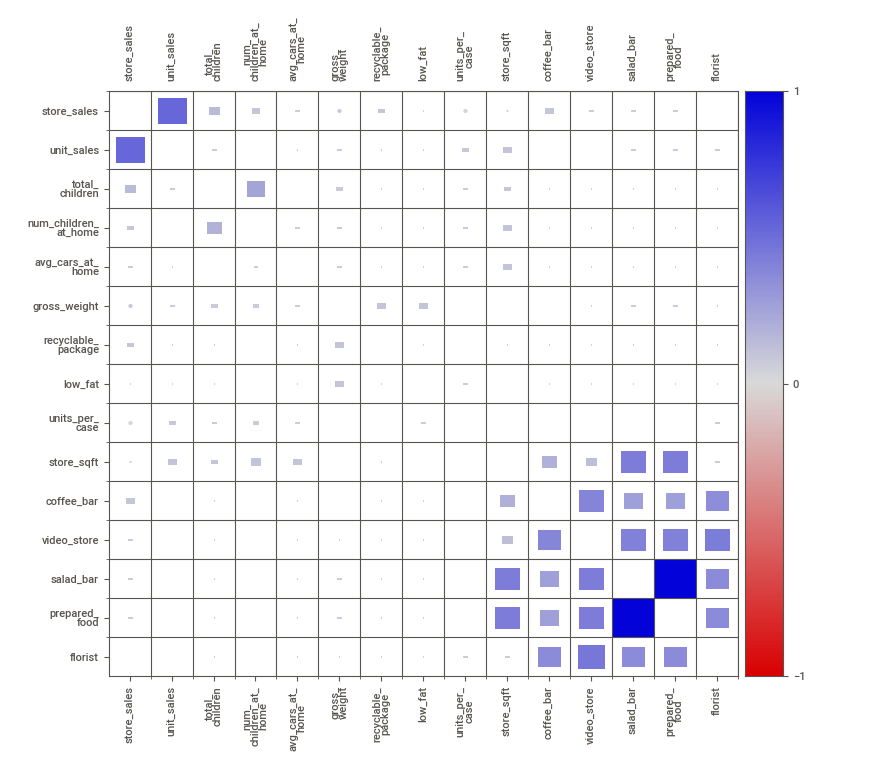

Report 'compare_report.html' was saved to storage.


In [ ]:
compare_report.show_notebook(w=None, filepath='compare_report.html')

# Custom EDA

In [ ]:
def summary(dfname,df):
    print(f'{dfname} Data Shape: {df.shape}')
    print(f'{dfname} # Duplicated Rows: {df.duplicated().sum()}')
    summary = pd.DataFrame(df.dtypes, columns=['data type'])
    summary['# missing'] = df.isnull().sum().values   # get the array of missing value count for each column
    summary['% missing'] = df.isnull().sum().values / len(df)   # divide each missing value count with tot no.of samples
    summary['# unique'] = df.nunique().values
    desc = df.describe(include='all').transpose() # returns a dataframe
    summary['min'] = desc['min'].values
    summary['max'] = desc['max'].values
    summary['1st row down'] = df.iloc[0].values
    summary['2nd row down'] = df.iloc[1].values
    summary['3rd row down'] = df.iloc[2].values
    summary['last row down'] = df.iloc[-1].values
    return summary

In [ ]:
for name, ele in arr:
    display(summary(name,ele))
    print('\n\n')

Train Data Shape: (51363, 16)
Train # Duplicated Rows: 35


data type  # missing  % missing  # unique       min  \
store_sales            float64          0        0.0      1030      0.51   
unit_sales             float64          0        0.0         6      1.00   
total_children         float64          0        0.0         6      0.00   
num_children_at_home   float64          0        0.0         6      0.00   
avg_cars_at_home       float64          0        0.0         5      0.00   
gross_weight           float64          0        0.0       376      6.00   
recyclable_package     float64          0        0.0         2      0.00   
low_fat                float64          0        0.0         2      0.00   
units_per_case         float64          0        0.0        36      1.00   
store_sqft             float64          0        0.0        20  20319.00   
coffee_bar             float64          0        0.0         2      0.00   
video_store            float64          0        0.0         2      0.00   
salad_bar              float64          0        0.0         2      0.00   
prepared_food          float64          0        0.0         2      0.00   
florist                float64          0        0.0         2      0.00   
cost                   float64          0        0.0       328     50.79   

                           max  1st row down  2nd row down  3rd row down  \
store_sales              22.92          2.68          5.73          2.62   
unit_sales                6.00          2.00          3.00          2.00   
total_children            5.00          1.00          5.00          1.00   
num_children_at_home      5.00          0.00          5.00          1.00   
avg_cars_at_home          4.00          2.00          3.00          1.00   
gross_weight             21.90          6.30         18.70          9.21   
recyclable_package        1.00          1.00          1.00          0.00   
low_fat                   1.00          0.00          0.00          0.00   
units_per_case           36.00         22.00         30.00          9.00   
store_sqft            39696.00      30584.00      20319.00      20319.00   
coffee_bar                1.00          1.00          0.00          0.00   
video_store               1.00          1.00          0.00          0.00   
salad_bar                 1.00          1.00          0.00          0.00   
prepared_food             1.00          1.00          0.00          0.00   
florist                   1.00          1.00          0.00          0.00   
cost                    149.75         79.59        118.36         67.20   

                      last row down  
store_sales                    2.91  
unit_sales                     3.00  
total_children                 1.00  
num_children_at_home           0.00  
avg_cars_at_home               4.00  
gross_weight                   9.80  
recyclable_package             1.00  
low_fat                        0.00  
units_per_case                18.00  
store_sqft                 39696.00  
coffee_bar                     0.00  
video_store                    0.00  
salad_bar                      1.00  
prepared_food                  1.00  
florist                        0.00  
cost                         129.50




Test Data Shape: (9065, 15)
Test # Duplicated Rows: 21


data type  # missing  % missing  # unique       min  \
store_sales            float64          0        0.0       844      0.51   
unit_sales             float64          0        0.0         6      1.00   
total_children         float64          0        0.0         6      0.00   
num_children_at_home   float64          0        0.0         6      0.00   
avg_cars_at_home       float64          0        0.0         5      0.00   
gross_weight           float64          0        0.0       376      6.00   
recyclable_package     float64          0        0.0         2      0.00   
low_fat                float64          0        0.0         2      0.00   
units_per_case         float64          0        0.0        36      1.00   
store_sqft             float64          0        0.0        20  20319.00   
coffee_bar             float64          0        0.0         2      0.00   
video_store            float64          0        0.0         2      0.00   
salad_bar              float64          0        0.0         2      0.00   
prepared_food          float64          0        0.0         2      0.00   
florist                float64          0        0.0         2      0.00   

                           max  1st row down  2nd row down  3rd row down  \
store_sales              19.75          2.65          8.34          3.54   
unit_sales                6.00          5.00          3.00          2.00   
total_children            5.00          4.00          0.00          4.00   
num_children_at_home      5.00          1.00          0.00          0.00   
avg_cars_at_home          4.00          4.00          1.00          2.00   
gross_weight             21.90          6.89          9.71         20.90   
recyclable_package        1.00          0.00          1.00          1.00   
low_fat                   1.00          1.00          1.00          0.00   
units_per_case           36.00          5.00         28.00         15.00   
store_sqft            39696.00      33858.00      20319.00      30797.00   
coffee_bar                1.00          1.00          0.00          1.00   
video_store               1.00          0.00          0.00          1.00   
salad_bar                 1.00          1.00          0.00          1.00   
prepared_food             1.00          1.00          0.00          1.00   
florist                   1.00          1.00          0.00          1.00   

                      last row down  
store_sales                    2.24  
unit_sales                     2.00  
total_children                 2.00  
num_children_at_home           0.00  
avg_cars_at_home               1.00  
gross_weight                  21.50  
recyclable_package             1.00  
low_fat                        0.00  
units_per_case                14.00  
store_sqft                 28206.00  
coffee_bar                     1.00  
video_store                    0.00  
salad_bar                      0.00  
prepared_food                  0.00  
florist                        0.00

- No high cardinality observed in any features.

- In general, if a variable can be placed into distinct categories or groups, it may be appropriate to consider it as a categorical variable. However, if the variable has a numerical value and can take any value within a range, it may be more appropriate to treat it as a continuous variable. <br>
Going by this logic we clearly have the following categorical variables:

In [ ]:
cat_fts = ['coffee_bar','video_store','salad_bar','prepared_food','florist','recyclable_package','low_fat']

* Since there's unit_sales, total_children, num_children_at_home and avg_cars_at_home features with menial count, let's see if they fall into the continuous category by looking at those unique values; if not, we consider them categorical too.

In [ ]:
for i,(name, ele) in enumerate(arr):
  print(f"{i+1}. Unique Values from {name} Data:\
  \nunit_sales: {ele['unit_sales'].unique()}\
  \ntotal_children: {ele['total_children'].unique()}\
  \nnum_children_at_home: {ele['num_children_at_home'].unique()}\
  \navg_cars_at_home: {ele['avg_cars_at_home'].unique()}\n")

1. Unique Values from Train Data:  
unit_sales: [2. 3. 5. 4. 1. 6.]  
total_children: [1. 5. 4. 0. 2. 3.]  
num_children_at_home: [0. 5. 1. 2. 3. 4.]  
avg_cars_at_home: [2. 3. 1. 4. 0.]

2. Unique Values from Test Data:  
unit_sales: [5. 3. 2. 4. 1. 6.]  
total_children: [4. 0. 3. 2. 5. 1.]  
num_children_at_home: [1. 0. 2. 4. 3. 5.]  
avg_cars_at_home: [4. 1. 2. 3. 0.]



* We can consider these distinct valued features as categorical and apply some encoding like OHE/Nominal Encoding.

In [ ]:
cat_fts.extend(['unit_sales', 'total_children', 'num_children_at_home', 'avg_cars_at_home'])

In [ ]:
for i,ft in enumerate(cat_fts):
  print(f"{i+1}. {ft}")

1. coffee_bar
2. video_store
3. salad_bar
4. prepared_food
5. florist
6. recyclable_package
7. low_fat
8. unit_sales
9. total_children
10. num_children_at_home
11. avg_cars_at_home


In [ ]:
num_fts=['store_sqft','units_per_case','gross_weight','store_sales']

- store_sqft, which has only twenty unique values, looks like a numerical feature, but it is categorical. We can use a partial dependency plot and corroborate this observation.

More on PDP [here.](https://www.kaggle.com/code/dansbecker/partial-dependence-plots)

In [ ]:
# Now, let's compare the key statistical measures of the training and testing data. why? data drifting
# https://stackoverflow.com/questions/48143318/distribution-of-the-training-data-vs-distribution-of-the-test-prediction
ntiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]

_train = traindf.drop([target], axis=1).describe(percentiles= ntiles).transpose().drop(['count'], axis=1)
_train.insert(0, 'source', 'train')
_train = _train.reset_index().set_index(['index', 'source'])

_test = testdf.drop([target], axis=1, errors= 'ignore').describe(percentiles= ntiles).transpose().drop(['count'], axis=1)
_test.insert(0, 'source', 'test')
_test = _test.reset_index().set_index(['index', 'source'])

display(pd.concat([_train, _test], axis=0).sort_index(ascending = [True, False]).style.format(formatter = '{:,.2f}'))
del ntiles, _train, _test

- The values do seem comparable.

## Univariate Analysis

### Target

0.03357760806173663


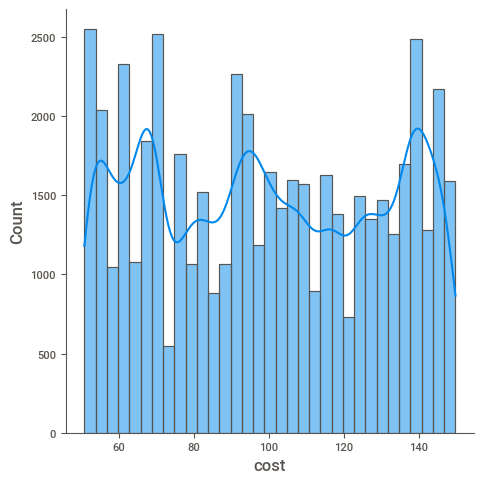

In [ ]:
from scipy.stats import skew
print(skew(traindf.cost)) # fairly symmetrical
sns.displot(x=traindf.cost, kde=True)

### Numerical Features

0it [00:00, ?it/s]

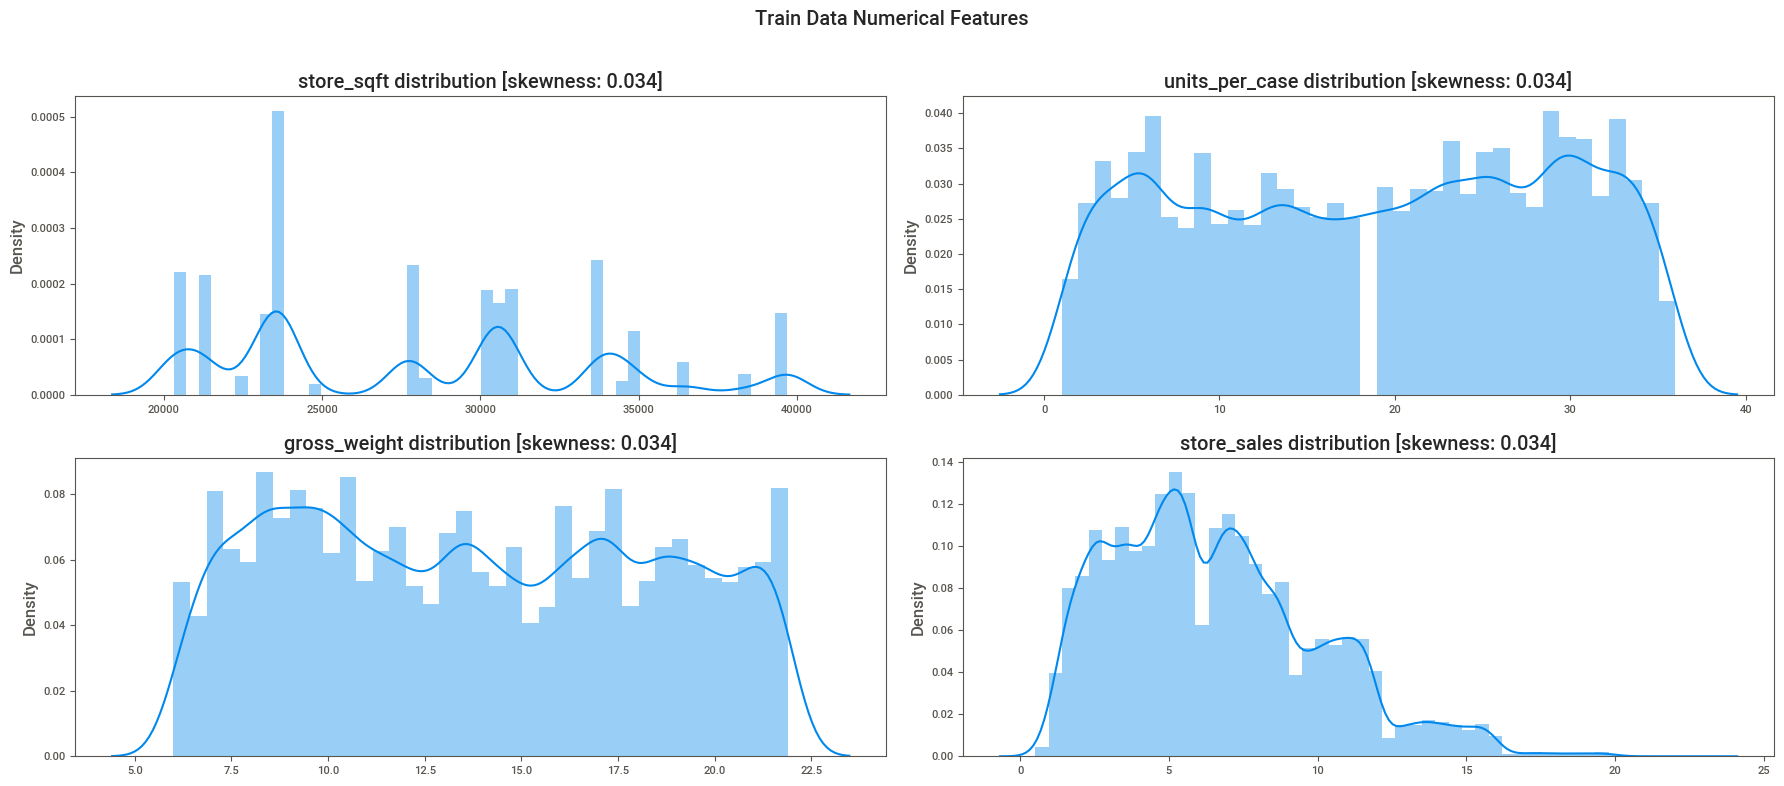

In [ ]:
import math

n_cols = 2
n_rows = math.ceil(len(num_fts)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
ax = ax.flatten()

for i, col in tqdm(enumerate(num_fts)):
    plot_axes = [ax[i]]
    sns.distplot(x=traindf[col], ax=ax[i])

    # titles
    ax[i].set_title(f'{col} distribution [skewness: {traindf[target].skew():.3f}]')
    ax[i].set_xlabel(None)

fig.suptitle(f'Train Data Numerical Features\n')
plt.tight_layout()

### Categorical Features

0it [00:00, ?it/s]

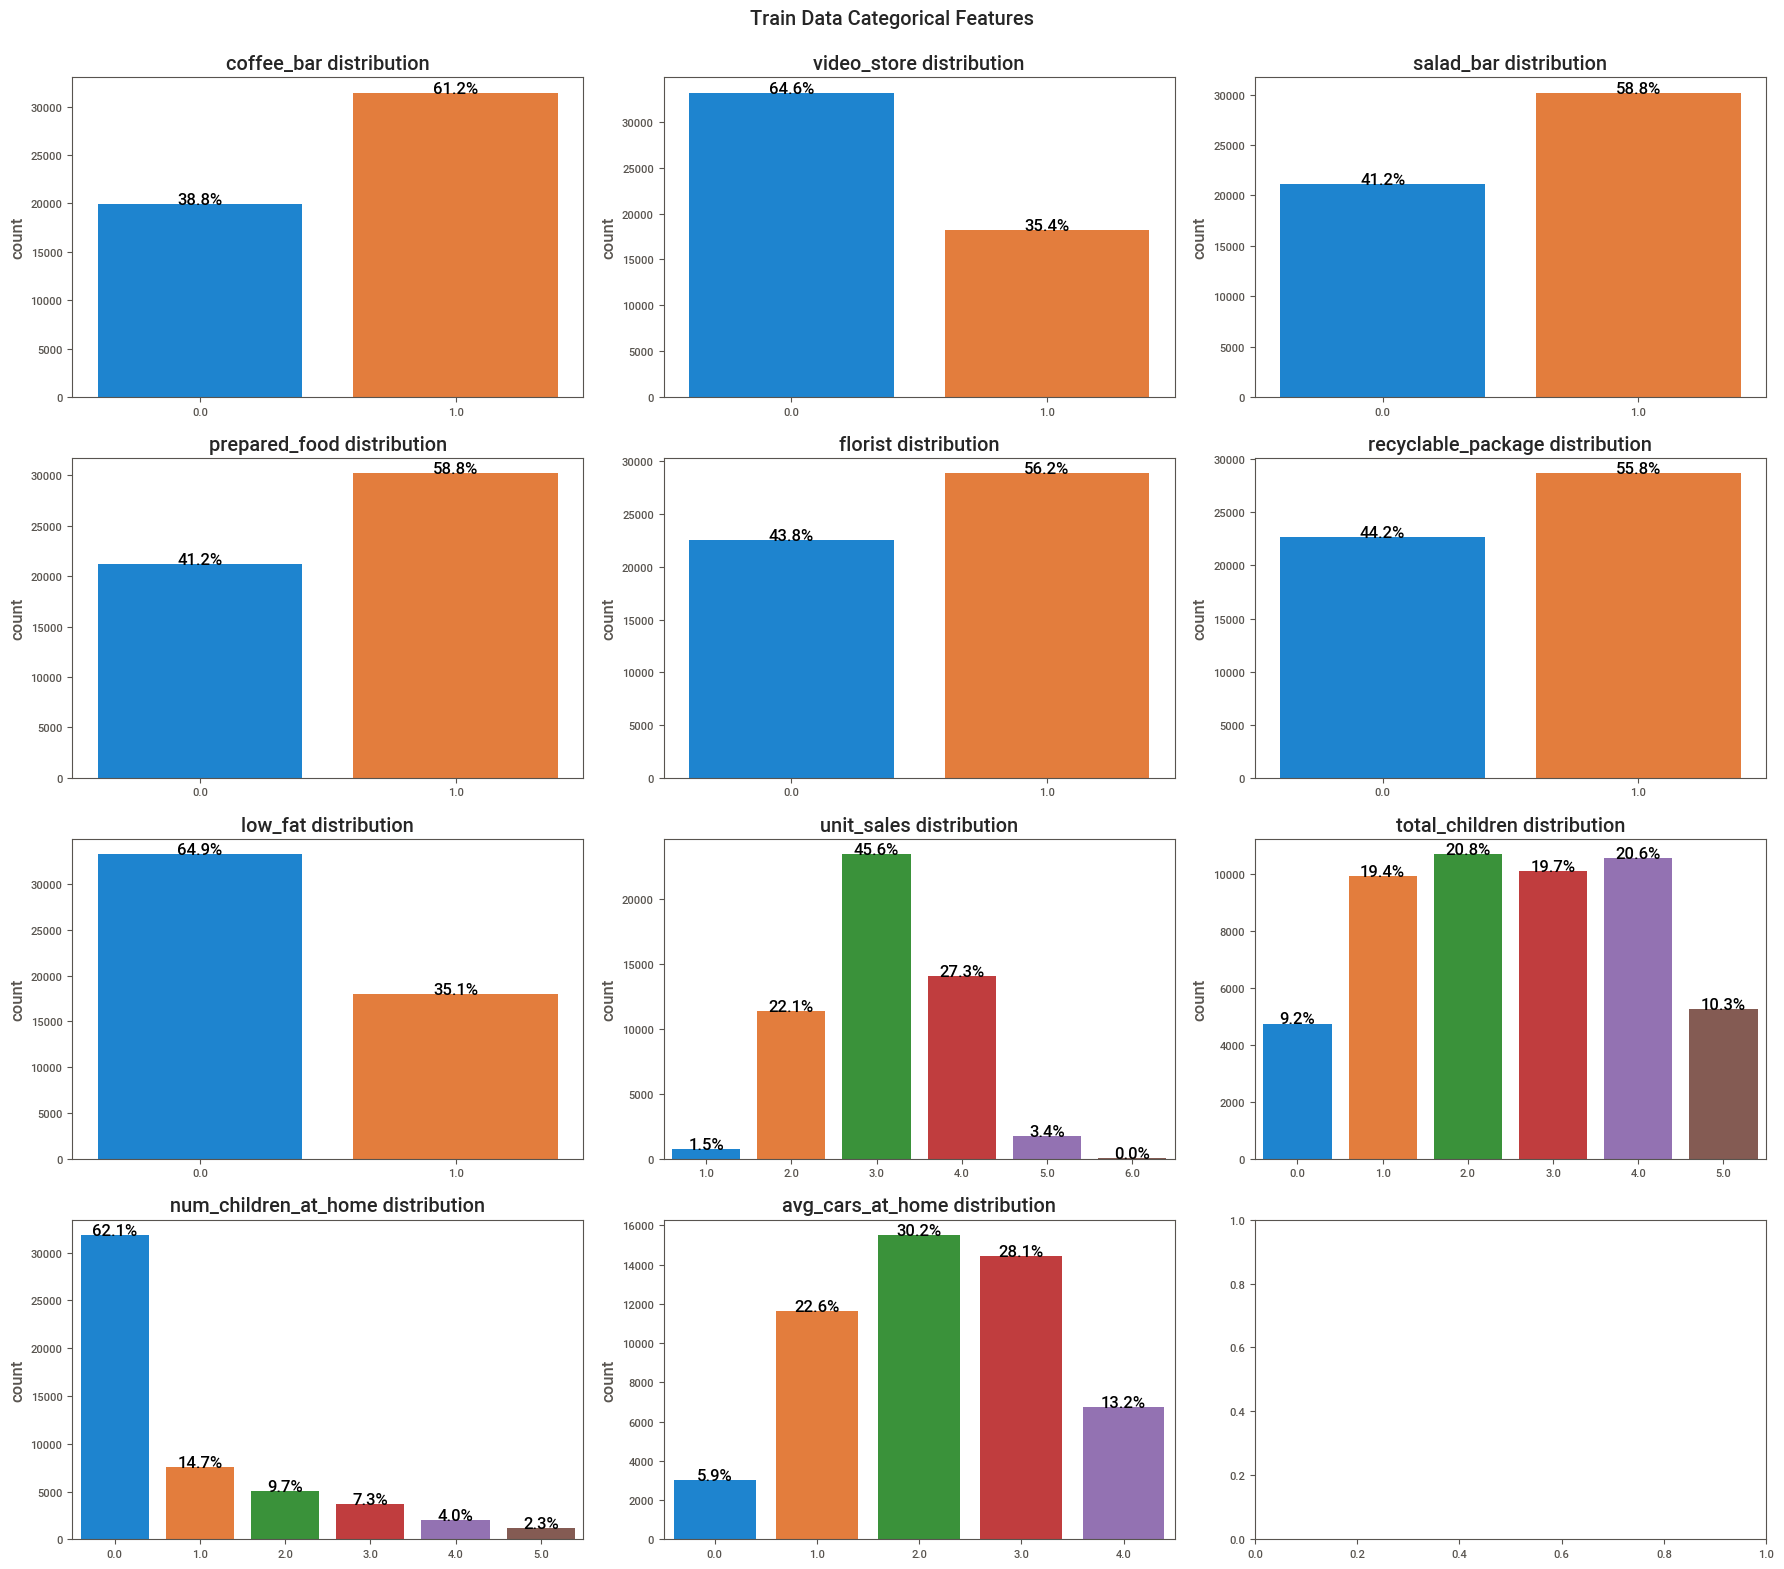

In [ ]:
n_cols = 3
n_rows = math.ceil(len(cat_fts)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
ax = ax.flatten()

for i, col in tqdm(enumerate(cat_fts)):
    plot_axes = [ax[i]]
    sns.countplot(x=traindf[col], ax=ax[i])

    # # foll. loop gives the count within each category displayed on top of each bar
    # for p in ax[i].patches:
    #   ax[i].annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()+0.5), ha='center', color='black', size=12)

    total = float(len(traindf))
    for p in ax[i].patches:
      height = p.get_height()
      percent = f'{100 * height / total:.1f}%'
      ax[i].annotate(percent, (p.get_x()+0.4, height+0.5), ha='center', color='black', size=12)


    # titles
    ax[i].set_title(f'{col} distribution')
    ax[i].set_xlabel(None)

fig.suptitle(f'Train Data Categorical Features\n')
plt.tight_layout()

* There is 0% of category 6.0 in unit_sales. We might want to drop it or treat it like a missing value (clip it with 5.0/imputation strategy).

## Bivariate Analysis

### Target Vs Categorical Features

0it [00:00, ?it/s]

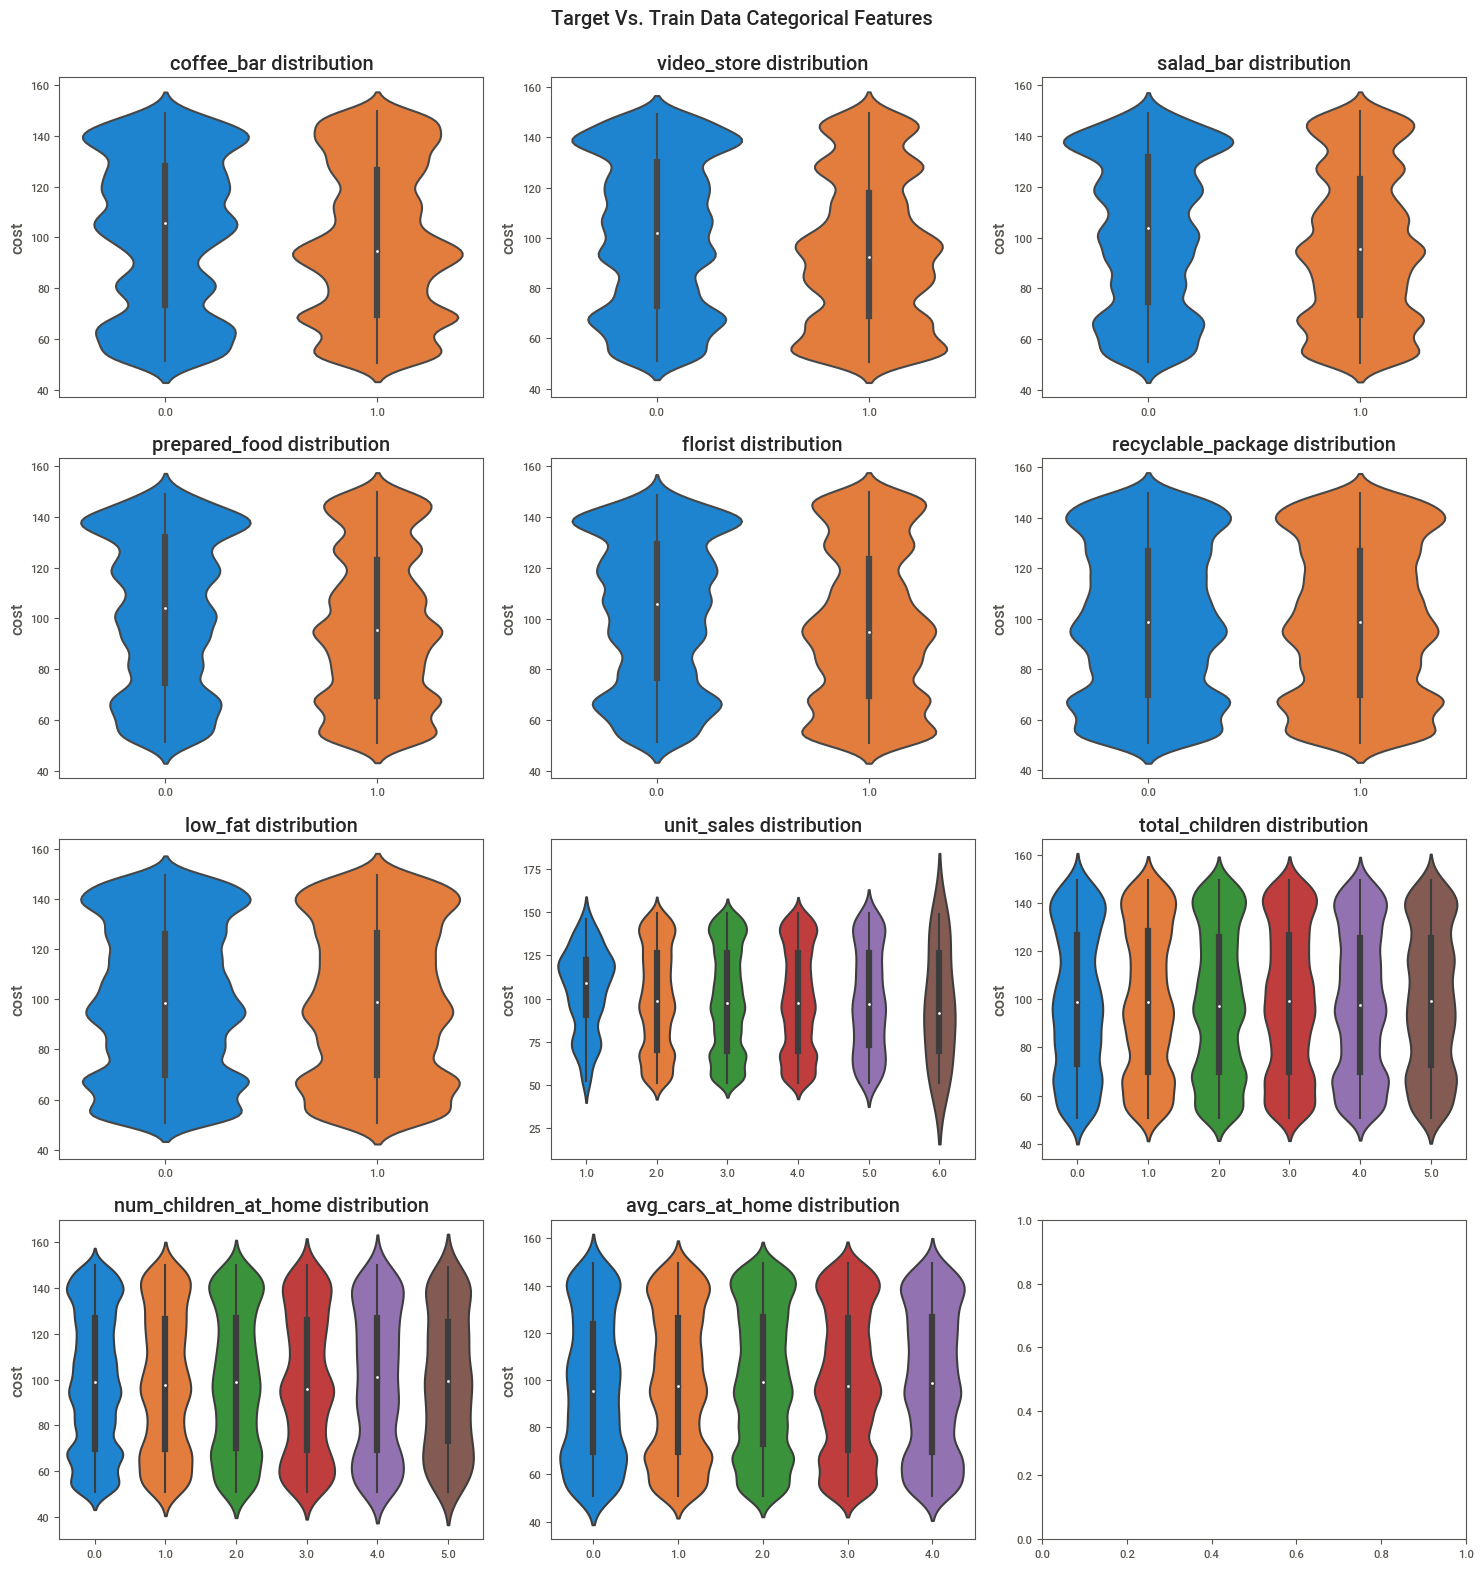

In [ ]:
n_cols = 3
n_rows = math.ceil(len(cat_fts)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
ax = ax.flatten()

for i, col in tqdm(enumerate(cat_fts)):
    plot_axes = [ax[i]]
    sns.violinplot(x=traindf[col], y=traindf[target], ax=ax[i])

    # titles
    ax[i].set_title(f'{col} distribution')
    ax[i].set_xlabel(None)

fig.suptitle(f'Target Vs. Train Data Categorical Features\n')
plt.tight_layout()

* Salad bar and prepared_food look the same. We might want to drop one of them and see if this reduces the loss. We can look at the correlation between them using heatmap.

### Target Vs Numerical Features

0it [00:00, ?it/s]

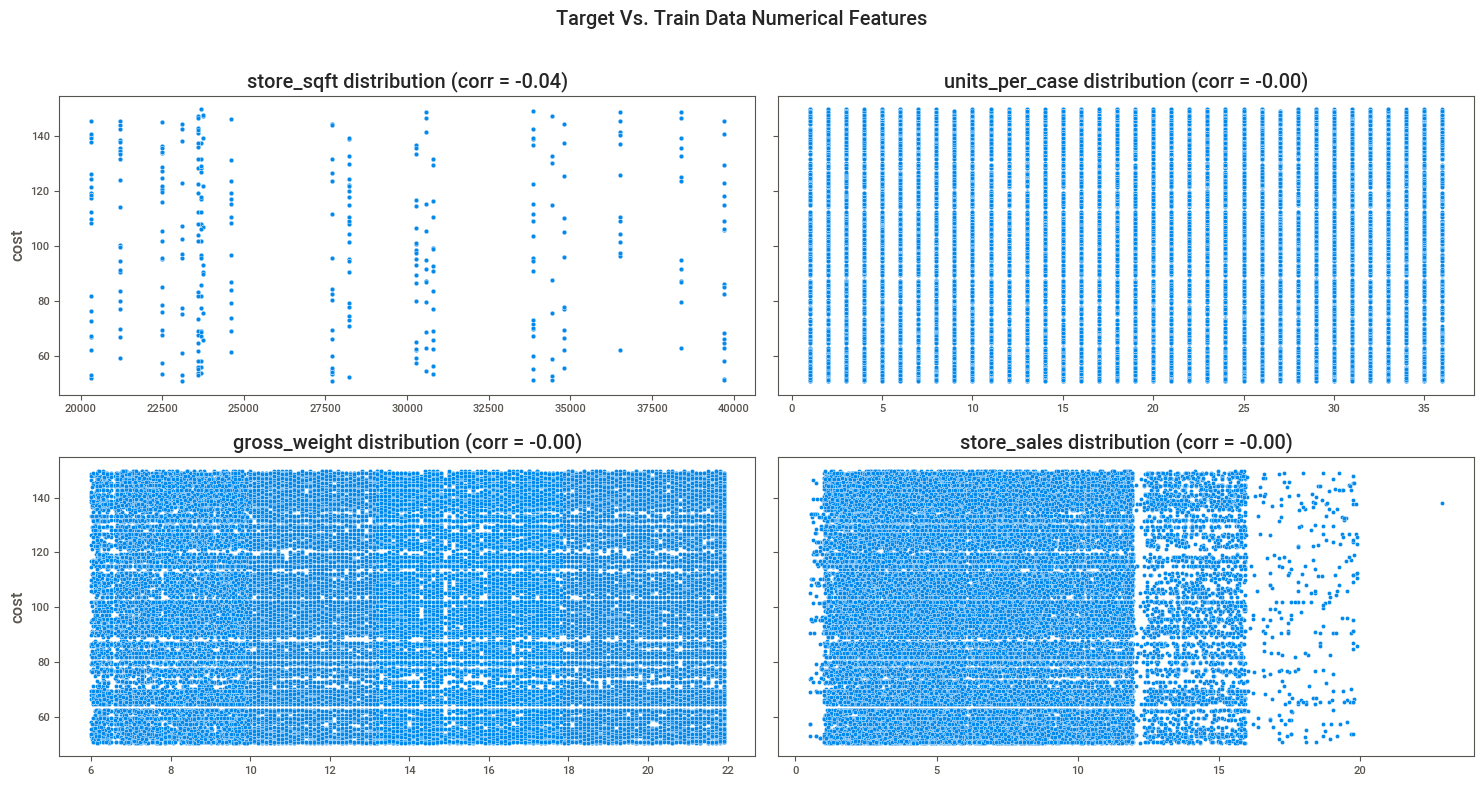

In [ ]:
n_cols = 2
n_rows = math.ceil(len(num_fts)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4), sharey=True)
ax = ax.flatten()

for i, col in tqdm(enumerate(num_fts)):
    plot_axes = [ax[i]]
    sns.scatterplot(data=traindf, x=col, y=target, ax=ax[i])

    # titles
    # ax[i].set_title(f'{col} distribution')
    corr = traindf[[col, target]].corr().iloc[0, 1]
    title = f'{col} distribution (corr = {corr:.2f})'
    ax[i].set_title(title)
    ax[i].set_xlabel(None)

fig.suptitle(f'Target Vs. Train Data Numerical Features\n')
plt.tight_layout()

### Correlation - Heatmap

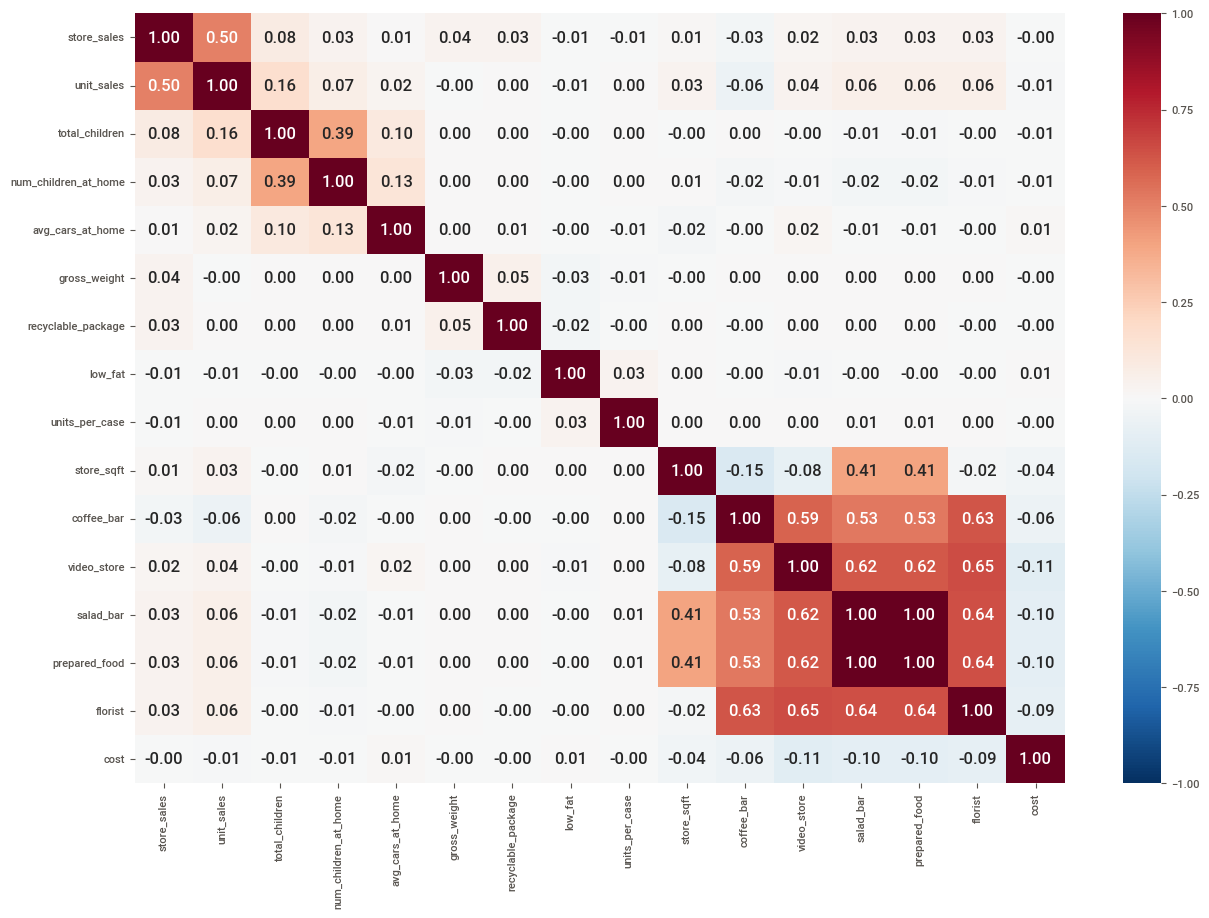

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(traindf.corr(), cmap="RdBu_r", annot=True, vmin=-1, vmax=1, fmt=f'.{2}f')
plt.show()

* salad_bar and prepared_food show correlation=1 which supports the observation from violin plot. It means that all the prepared food comes from the salad bar.
* There are some moderate positive correlations 0.5-0.6 between features, but overall features uncorrelated. We can engineer features from these but from Kaggle Discussions it does not improve CV score so we won't.
* We can engineer two new features from num_children_at_home and total_children: ratio of children at home and number of independent children.

# Evaluation Metric

The Root Mean Squared Logarithmic Error (RMSLE) is a metric commonly used to evaluate the accuracy of a model's predictions when dealing with regression problems, especially when the target variable has a wide range. The formula for RMSLE is as follows:

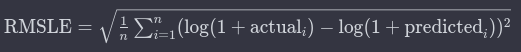

where:

    n is the number of observations or data points.
    actuali​ is the actual value of the target variable for the i-th observation.
    predictedi​ is the predicted value of the target variable for the i-th observation.
    log⁡ denotes the natural logarithm.

The use of log⁡(1+x) is common in RMSLE to handle cases where the target variable or predictions might have zero or negative values.
Adding 1 to the values inside the logarithm helps to avoid undefined results when the logarithm is taken of zero.

To compute RMSLE:

    Take the natural logarithm of 1+actuali​ for each observation.
    Take the natural logarithm of 1+predictedi for each observation.
    Calculate the squared difference between the logged actual and logged predicted values for each observation.
    Take the mean of these squared differences.
    Take the square root of the mean to obtain the final RMSLE value.

RMSLE penalizes, underestimates and overestimates proportionally to the magnitude of the actual values, making it suitable for scenarios where the target variable has a wide range.

In [99]:
from sklearn.metrics import mean_squared_log_error

def rmsle_custom(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred, squared=False)

# Feature Engineering

In [10]:
from sklearn.base import TransformerMixin

class FeatureEngineeringTransformer(TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['salad'] = (X_copy['salad_bar'] + X_copy['prepared_food']) / 2 # prepared_food is basically just salad, so we just turn it into the feature if salad is available in the store
        X_copy['unit_sales'] = X_copy['unit_sales'].clip(0, 5)
        X_copy['children_ratio'] = X_copy['total_children'] / X_copy['num_children_at_home'] # divides by zero too so inf is bound to occur
        X_copy['children_ratio'] = X_copy['children_ratio'].replace([np.inf, -np.inf], 10) # replace those inf values with 10
        X_copy.fillna(0, inplace=True)
        X_copy['facilities'] = X_copy.eval('coffee_bar + video_store + salad_bar + florist') # add up the boolean values
        X_copy['independent_child'] = X_copy.eval('total_children - num_children_at_home')

        ## this was done for transformed target
        # if y is not None:
        #     y_copy = y.copy()
        #     y_copy = np.log1p(y_copy)
        #     return X_copy, y_copy
        # else:
        return X_copy

In [109]:
fe_transformer = FeatureEngineeringTransformer()
X_train_transformed = fe_transformer.transform(traindf)
X_test_transformed = fe_transformer.transform(testdf)

In [110]:
X_train_transformed

store_sales  unit_sales  total_children  num_children_at_home  \
0             2.68         2.0             1.0                   0.0   
1             5.73         3.0             5.0                   5.0   
2             2.62         2.0             1.0                   1.0   
3            11.73         3.0             1.0                   1.0   
4             4.82         2.0             1.0                   1.0   
...            ...         ...             ...                   ...   
51358         3.70         2.0             4.0                   4.0   
51359        10.36         4.0             2.0                   0.0   
51360        11.19         3.0             3.0                   0.0   
51361         3.78         3.0             1.0                   1.0   
51362         2.91         3.0             1.0                   0.0   

       avg_cars_at_home  gross_weight  recyclable_package  low_fat  \
0                   2.0          6.30                 1.0      0.0   
1                   3.0         18.70                 1.0      0.0   
2                   1.0          9.21                 0.0      0.0   
3                   3.0         10.90                 1.0      1.0   
4                   3.0          8.15                 0.0      0.0   
...                 ...           ...                 ...      ...   
51358               1.0         10.40                 1.0      1.0   
51359               2.0          9.43                 0.0      0.0   
51360               3.0         18.50                 0.0      0.0   
51361               2.0         19.80                 0.0      1.0   
51362               4.0          9.80                 1.0      0.0   

       units_per_case  store_sqft  coffee_bar  video_store  salad_bar  \
0                22.0     30584.0         1.0          1.0        1.0   
1                30.0     20319.0         0.0          0.0        0.0   
2                 9.0     20319.0         0.0          0.0        0.0   
3                15.0     23112.0         1.0          1.0        1.0   
4                 7.0     38382.0         0.0          0.0        0.0   
...               ...         ...         ...          ...        ...   
51358            18.0     34452.0         1.0          0.0        0.0   
51359            20.0     30797.0         1.0          1.0        1.0   
51360             5.0     30797.0         1.0          1.0        1.0   
51361             8.0     23598.0         0.0          0.0        0.0   
51362            18.0     39696.0         0.0          0.0        1.0   

       prepared_food  florist    cost  salad  children_ratio  facilities  \
0                1.0      1.0   79.59    1.0            10.0         4.0   
1                0.0      0.0  118.36    0.0             1.0         0.0   
2                0.0      0.0   67.20    0.0             1.0         0.0   
3                1.0      1.0   60.87    1.0             1.0         4.0   
4                0.0      0.0   86.79    0.0             1.0         0.0   
...              ...      ...     ...    ...             ...         ...   
51358            0.0      1.0  147.17    0.0             1.0         2.0   
51359            1.0      1.0   92.57    1.0            10.0         4.0   
51360            1.0      1.0   92.57    1.0            10.0         4.0   
51361            0.0      1.0  135.92    0.0             1.0         1.0   
51362            1.0      0.0  129.50    1.0            10.0         1.0   

       independent_child  
0                    1.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
51358                0.0  
51359                2.0  
51360                3.0  
51361                0.0  
51362                1.0  

[51363 rows x 20 columns]

# Feature Importance

In [111]:
from sklearn.model_selection import KFold

SEED = 42
X = X_train_transformed.drop('cost',axis=1)
y = X_train_transformed.cost
N_SPLITS = 5 # about 50k in the dataset, if we take 5 then each fold has 10k
k = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

In [112]:
X.shape

(51363, 19)

In [113]:
y.sample(5)

30185     59.86
9961     114.60
26225    115.25
23449    138.18
48392    120.09
Name: cost, dtype: float64

In [114]:
# X.info() # dtype of all columns is float64
X = X.astype(int)
# X.info() # now it's int64 (catboost works with int or string)

In [ ]:
# # Select fold and make sure each fold has a similar distribution for target:
# # this isn't as necessary as it would be in classification task where we anyways use StratifiedKFold
# traindf.cost.hist()

In [ ]:
# from sklearn.model_selection import KFold

# N_SPLITS = 5 # about 50k in the dataset, if take 5 then each fold has 10k
# k = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

In [ ]:
# traindf['fold'] = -1

In [ ]:
# for fold, (train_idx, val_idx) in enumerate(k.split(X)):
#   traindf.loc[val_idx,'fold'] = fold

In [ ]:
# traindf.fold.value_counts()

In [ ]:
# traindf[traindf.fold==4].cost.hist()

In [ ]:
# traindf.drop('fold',axis=1)

In [13]:
# Let's train an XGBoost model to get the feature importance
xgb_params = {
    'seed': SEED,
    'booster': 'gbtree',
    'device' : 'gpu',
    'verbosity': 1,
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle',
    'tree_method' : 'gpu_hist',
    'n_jobs' : -1,
    'importance_type' : 'gain', # try out total_gain, cover, total_cover, weight too
    'max_depth' : 12,
    'n_estimators': 100
}

xgb_importance = np.zeros(len(list(X))) # array with val 0 for every feature in X

In [20]:
from xgboost import XGBRegressor
import xgboost as xgb

for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
  # Split the data from the current fold into training and validation sets
  X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
  y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

  xgb_model = XGBRegressor(**xgb_params,
                           callbacks=[
                               xgb.callback.EarlyStopping(
                                   rounds=10,
                                   maximize=False,
                                   save_best=True
                                )
                            ]
                          )

  xgb_model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = False)
  xgb_importance += xgb_model.feature_importances_ / N_SPLITS

In [ ]:
xgb_info = pd.DataFrame(xgb_importance, index = list(X))
# sns.barplot(xgb_info.sort_values(ascending=False, by=0).T, orient='h')
# plt.suptitle('Feature Importance (XGBoost)')
# plt.tight_layout()

In [ ]:
# let's see how an lgbm model does when crunching out feature importance values
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

lgb_params = {
    'seed': SEED,
    'objective': 'regression',
    'metric': 'custom',
    'importance_type' : 'gain',
    'max_depth' : 12,
    'n_estimators': 100,
    'verbosity': -1
}

def rmsle_lgbm(y_pred, data):
  y_true = np.array(data)
  score = mean_squared_log_error(y_true, y_pred, squared = False)
  return 'rmsle', score, False

lgb_importance = np.zeros(len(list(X)))

for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    # Split the data from the current fold into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgb_model = LGBMRegressor(**lgb_params)

    lgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  eval_metric = rmsle_lgbm,
                  callbacks = [lgb.log_evaluation(False),
                               lgb.early_stopping(stopping_rounds=10)])

    lgb_importance += lgb_model.feature_importances_ / N_SPLITS

lgb_info = pd.DataFrame(lgb_importance, index=list(X), columns=['Importance'])

# Sort features based on importance
lgb_info = lgb_info.sort_values(by='Importance', ascending=False)

# Plot feature importance
# sns.barplot(x=lgb_info['Importance'], y=lgb_info.index, orient='h')
# plt.suptitle('Feature Importance (LightGBM)')
# plt.tight_layout()
# plt.show()

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's rmsle: 0.310152
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmsle: 0.308918
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	valid_0's rmsle: 0.310887
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	valid_0's rmsle: 0.312276
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's rmsle: 0.31386


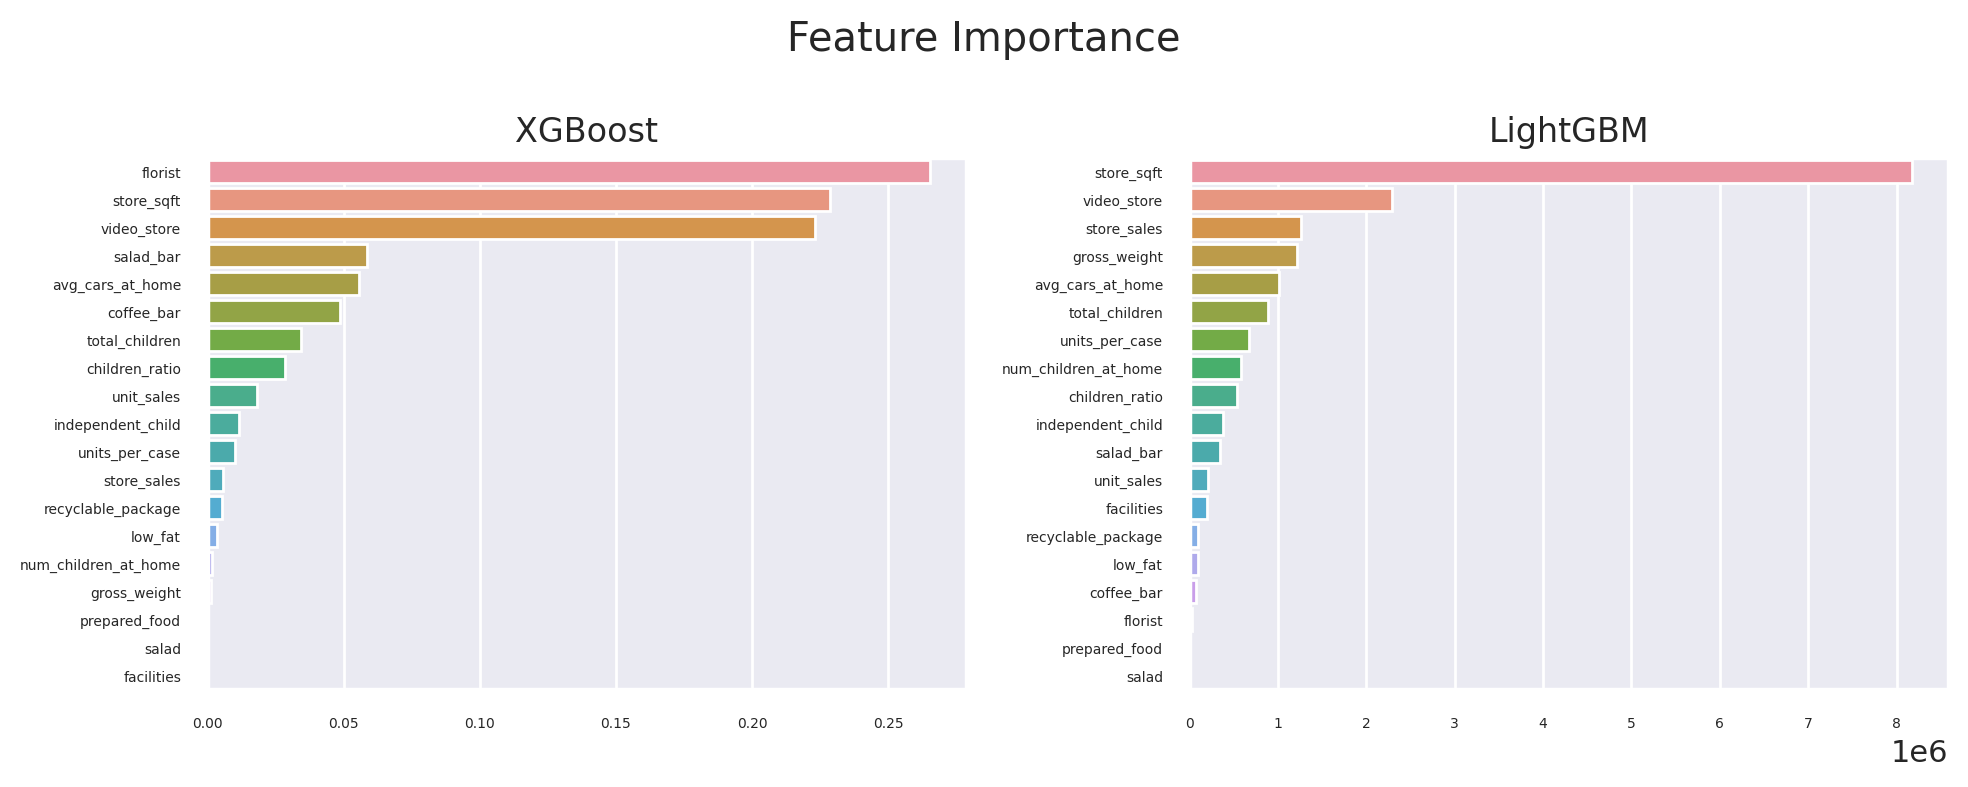

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,4), dpi=200)
ax = ax.flatten()

sns.barplot(xgb_info.sort_values(ascending = False, by = 0).T, orient = 'h', ax = ax[0])
ax[0].set_title('XGBoost')
ax[0].tick_params(axis = 'both', which = 'major', labelsize = 5)

sns.barplot(lgb_info.sort_values(ascending = False, by = 'Importance').T, orient = 'h', ax = ax[1])
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 5)
ax[1].set_title('LightGBM')

fig.suptitle('Feature Importance')
plt.tight_layout()

It seems only a few of the features are doing a good job with tree based models.


In [115]:
fts_to_drop = [
    'low_fat',
    'gross_weight',
    'recyclable_package',
    'store_sales',
    'units_per_case',
    'unit_sales',
    'prepared_food',
    'salad',
    'facilities',
]

In [116]:
X.drop(fts_to_drop, axis = 1, inplace = True)

In [117]:
X_test_transformed.drop(fts_to_drop, axis = 1, inplace = True)

In [118]:
list(X_test_transformed)

['total_children',
 'num_children_at_home',
 'avg_cars_at_home',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'florist',
 'children_ratio',
 'independent_child']

# Utility functions

In [103]:
# for cross validation
import datetime
# from joblib import Parallel, delayed
result_list = []

def score_model(model, label=None):
  start_time = datetime.datetime.now()
  rmsle_cv_score_list = []
  oof_predictions = np.zeros_like(y, dtype=float)

  for fold, (train_idx, val_idx) in enumerate(k.split(X)):
      X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
      y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

      model.fit(X_train, y_train)
      y_val_pred = model.predict(X_val)
      rmsle = rmsle_custom(y_val, y_val_pred)
      print(f"Fold {fold+1}: rmse = {rmsle:.5f}")
      oof_predictions[val_idx] = y_val_pred
      rmsle_cv_score_list.append(rmsle)

  rmsle = sum(rmsle_cv_score_list) / len(rmsle_cv_score_list)
  execution_time = datetime.datetime.now() - start_time
  print(f"Average rmsle: {rmsle:.5f}")
  global result_list
  result_list.append((label, model, rmsle, oof_predictions, execution_time))

# def train_fold(fold, train_idx, val_idx, X, y, model):
#   X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#   y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
#   model.fit(X_train, y_train)
#   y_val_pred = model.predict(X_val)
#   rmsle = rmsle_custom(y_val, y_val_pred)
#   print(f"Fold {fold+1}: rmse = {rmsle:.5f}")
#   return rmsle

# def score_model_parallel(model, label=None):
#   """
#   Cross-validate given model
#   """
#   start_time = datetime.datetime.now()
#   rmsle_cv_score_list = []
#   oof_predictions = np.zeros_like(y, dtype=float)

#   results = Parallel(n_jobs=-1)(
#       delayed(train_fold)(fold, train_idx, val_idx, X, y, model)
#       for fold, (train_idx, val_idx) in enumerate(k.split(X))
#   )
#   rmsle_cv_score_list.extend(results)
#   rmsle = sum(rmsle_cv_score_list) / len(rmsle_cv_score_list)
#   execution_time = datetime.datetime.now() - start_time
#   print(f"Average rmsle: {rmsle:.5f}")
#   global result_list
#   result_list.append((label, model, rmsle, oof_predictions, execution_time))

In [18]:
from sklearn.model_selection import train_test_split

def plot_learning_curve(model, model_name):
  """ Plot the Learning Curve: Training Loss Vs. Validation Loss
      See the learning curve to get an idea of how the model is generalizing.
      Ref. to read about Learning Curves: https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5
      - Typical features of the learning curve of a good fit model:
        -- Training loss and Validation loss are close to each other with validation loss being slightly greater than the training loss.
        -- Initially decreasing training and validation loss and a pretty flat training and validation loss after some point till the end.
  """
  train_rmsle = []
  val_rmsle = []

  for i in range(1, 100):
      # Train the model with a subset of the training data
      subset_size = int(len(X_train) * i / 100)
      X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=SEED)

      model.fit(X_subset, y_subset)

      y_train_pred = model.predict(X_subset)
      y_val_pred = model.predict(X_val)

      train_rmsle.append(rmsle_custom(y_subset, y_train_pred))
      val_rmsle.append(rmsle_custom(y_val, y_val_pred))

  # Plot the learning curve
  plt.plot(train_rmsle, label='Training RMSLE')
  plt.plot(val_rmsle, label='Validation RMSLE')
  plt.title(f'{model_name} Learning Curve')
  plt.xlabel('Training Set Size (%)')
  plt.ylabel('RMSLE')
  plt.legend()
  plt.show()

# XGB Model

Here, we'll try and go the raw route without using any utility functions to understand the nooks and corners of how those functions were devised to work for a variety of models as well as see hyperparameter tuning in action.

In [19]:
!pip3 install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00


## Hyperparameter Tuning with Optuna

In [ ]:
import optuna
from xgboost import XGBRegressor

def objective(trial):
    xgb_params = {
        'seed': SEED,
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'tree_method': 'gpu_hist',
        # 'tree_method': 'hist',
        'n_jobs': -1,
        'importance_type': 'total_gain',
        'grow_policy': 'lossguide',
        'n_estimators': 1000,
        'eta': trial.suggest_float('eta', 0.0001, 0.1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 0, 10),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 40)
    }

    scores = []
    for train_idx, val_idx in k.split(X,y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**xgb_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        rmsle = rmsle_custom(y_val, y_pred)
        scores.append(rmsle)

    return np.mean(scores)

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=50)

In [ ]:
best_params = study.best_params
best_score = study.best_value

print("Best Score:", best_score)
print("Best Parameters:", best_params)

Best Score: 0.31284113219888887
Best Parameters: {'eta': 0.09803239047375573, 'min_child_weight': 1, 'lambda': 5.296472282923108, 'alpha': 0.5401269314615912, 'gamma': 0.035610908484940015, 'subsample': 0.7855681439189597, 'colsample_bytree': 0.582868614748634, 'max_depth': 18}


## Model Training

In [ ]:
# Best Score : 0.31284113219888887
xgb_best_params = {
    'eta': 0.09803239047375573,
    'min_child_weight': 1,
    'lambda': 5.296472282923108,
    'alpha': 0.5401269314615912,
    'gamma': 0.035610908484940015,
    'subsample': 0.7855681439189597,
    'colsample_bytree': 0.582868614748634,
    'max_depth': 18,
    'verbose': -1
  }

In [34]:
def train_and_evaluate_tree_model_kfold(model, params):
  oof_predictions = np.zeros_like(y, dtype=float)
  rmsle_cv_scores = []

  for i,(train_idx, val_idx) in enumerate(k.split(X)):
      X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
      y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

      model_instance = model(**params)
      model_instance.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
      oof_predictions[val_idx] = model_instance.predict(X_val)

      # Calculate RMSLE for the current fold
      rmsle_fold = rmsle_custom(y_val, oof_predictions[val_idx])
      rmsle_cv_scores.append(rmsle_fold)
      print(f'RMSLE for Fold {i+1}: {rmsle_fold}')

  # Calculate overall RMSLE
  rmsle_mean = np.mean(rmsle_cv_scores)
  print(f'Mean RMSLE over {N_SPLITS} folds: {rmsle_mean}')
  return oof_predictions, rmsle_mean

In [ ]:
from xgboost import XGBRegressor
xgb_oof_predictions, xgb_rmsle_mean = train_and_evaluate_tree_model_kfold(XGBRegressor, xgb_best_params)

RMSLE for Fold 1: 0.3028224504158432
RMSLE for Fold 2: 0.3002222332312455
RMSLE for Fold 3: 0.30341616717693765
RMSLE for Fold 4: 0.303714558849606
RMSLE for Fold 5: 0.30604576024200814
Mean RMSLE over 5 folds: 0.3032442339831281


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)
xgb_model = XGBRegressor(**xgb_best_params)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
y_pred = xgb_model.predict(X)
rmsle = rmsle_custom(y, y_pred)
print(f'Training RMSLE: {rmsle}')

Training RMSLE: 0.2992792436778921


In [ ]:
xgb_oof_predictions.shape

(51363,)

- The **mean rmsle score over 5 folds** is slightly **higher than** the **training rmsle** score. This could be indicative of some overfitting, but it's not pronounced. We can say that the model is performing reasonably well in terms of generalization to the validation set.

In [ ]:
from sklearn.metrics import train_test_split

def plot_learning_curve(model, model_name):
  train_rmsle = []
  val_rmsle = []

  for i in range(1, 100):
      # Train the model with a subset of the training data
      subset_size = int(len(X_train) * i / 100)
      X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=SEED)

      model.fit(X_subset, y_subset)

      y_train_pred = model.predict(X_subset)
      y_val_pred = model.predict(X_val)

      train_rmsle.append(rmsle_custom(y_subset, y_train_pred))
      val_rmsle.append(rmsle_custom(y_val, y_val_pred))

  # Plot the learning curve
  plt.plot(train_rmsle, label='Training RMSLE')
  plt.plot(val_rmsle, label='Validation RMSLE')
  plt.title(f'{model_name} Learning Curve')
  plt.xlabel('Training Set Size (%)')
  plt.ylabel('RMSLE')
  plt.legend()
  plt.show()

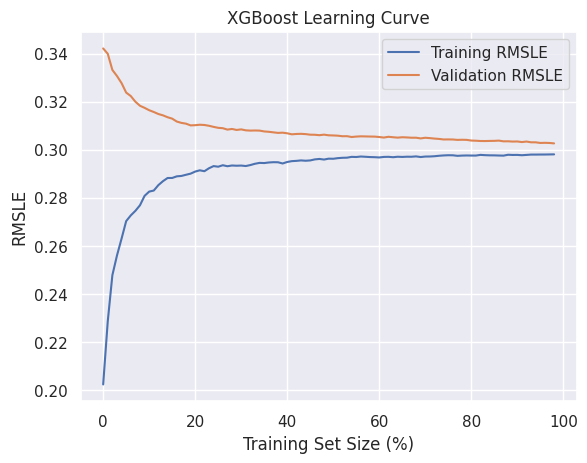

In [ ]:
plot_learning_curve(xgb_model, "XGBoost")

- Looks like we do have a good fit model.

# Catboost Model

## Hyperparameter Tuning with Optuna

In [20]:
!pip3 install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.0 MB/s eta 0:00:00


In [ ]:
# from catboost import CatBoostRegressor
# import optuna

# # catboost does not have optimization for msle and it does not have rmsle
# # by optimizing rmse we're implicitly finding parameters that minimize rmsle
# def objective(trial):
#     catboost_params = {
#         'n_estimators': 1000,
#         'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
#         'max_depth': trial.suggest_int('max_depth', 2, 16),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 100, log=True),
#         # 'random_strength': trial.suggest_float('random_strength', 0, 1),
#         # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 10, log=True),
#         # 'bootstrap_type' : 'Bayesian',
#         # 'border_count': trial.suggest_int('border_count', 1, 255),
#         # 'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 16),
#         'bootstrap_type' : 'Bernoulli',
#         # 'grow_policy': 'Lossguide',
#         'task_type': 'GPU',
#         # 'cat_features': [3, 4, 5, 6, 7],  # Specify indices of categorical
#         'thread_count': -1,  # Use all available threads
#         'loss_function': 'RMSE',
#         'eval_metric': 'RMSE',
#         'verbose': False
#     }

#     scores = []

#     for train_idx, val_idx in k.split(X, y):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         model = CatBoostRegressor(**catboost_params)
#         model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=20, verbose=False)

#         y_pred = model.predict(X_val)

#         rmsle = rmsle_custom(y_val, y_pred)
#         scores.append(rmsle)

#     return np.mean(scores)

# study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
# study.optimize(objective, n_trials=50)

In [ ]:
# best_params = study.best_params
# best_score = study.best_value

# print("Best Score:", best_score)
# print("Best Parameters:", best_params)

## Model Training

In [21]:
cb_best_params = {
    'random_seed': SEED,
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    # 'task_type' : 'GPU',
    'bootstrap_type' : 'Bernoulli',
    'verbose' : False,
    'n_estimators' : 1000,
    'max_depth' : 11,
    'learning_rate' : .09373739891212098, # eta
    'min_data_in_leaf' : 1,
    'l2_leaf_reg' : 10, # reg_lambda
    'subsample' : 1 # sample rate for bagging
}

In [35]:
from catboost import CatBoostRegressor
cb_oof_predictions, cb_rmsle_mean = train_and_evaluate_tree_model_kfold(CatBoostRegressor, cb_best_params)

RMSLE for Fold 1: 0.30192888423871184
RMSLE for Fold 2: 0.2994311079711539
RMSLE for Fold 3: 0.3027746562887976
RMSLE for Fold 4: 0.30279024683504296
RMSLE for Fold 5: 0.3051130972713926
Mean RMSLE over 5 folds: 0.3024075985210198


In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)
cb_model = CatBoostRegressor(**cb_best_params)
cb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
y_pred = cb_model.predict(X)
rmsle = rmsle_custom(y, y_pred)
print(f'Training RMSLE: {rmsle}')

Training RMSLE: 0.29707241436805865


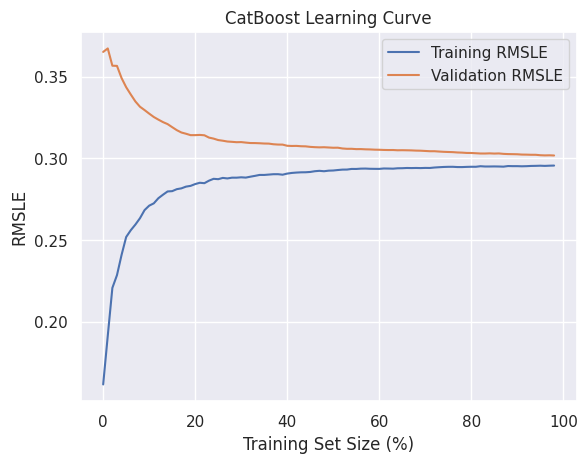

In [ ]:
plot_learning_curve(cb_model, "CatBoost")

# LightGBM

In [22]:
lgb_best_params = {
    'learning_rate': 0.1,
    'n_estimators': 450,
    'num_leaves': 100,
    'min_child_samples': 1,
    'min_child_weight': 1e1,
    'categorical_feature': [list(X).index('store_sqft')],
    'random_state': SEED,
    'early_stopping_round': 10,
    'objective': 'regression',
    'verbose': -1
}

In [37]:
import lightgbm as lgb

lgb_oof_predictions = np.zeros_like(y, dtype=float)
rmsle_cv_scores = []

for train_idx, val_idx in k.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_val, y_val, reference=dtrain)

    lgb_model = lgb.train(
        params = {**lgb_best_params},
        train_set=dtrain,
        valid_sets=[dvalid],
      )

    lgb_oof_predictions[val_idx] = lgb_model.predict(X_val)

    # Calculate RMSLE for the current fold
    rmsle_fold = rmsle_custom(y_val, lgb_oof_predictions[val_idx])
    rmsle_cv_scores.append(rmsle_fold)
    print(f'RMSLE for Fold: {rmsle_fold}')

# Calculate overall RMSLE
rmsle_mean = np.mean(rmsle_cv_scores)
print(f'Mean RMSLE over {N_SPLITS} folds: {rmsle_mean}')

RMSLE for Fold: 0.30228709594249564
RMSLE for Fold: 0.29944497893261035
RMSLE for Fold: 0.3029119144657605
RMSLE for Fold: 0.30274940568506814
RMSLE for Fold: 0.30554658970562265
Mean RMSLE over 5 folds: 0.3025879969463115


In [ ]:
lgb_oof_predictions.shape

(51363,)

In [40]:
y_pred = lgb_model.predict(X)
rmsle = rmsle_custom(y, y_pred)
print(f'Training RMSLE: {rmsle}')

Training RMSLE: 0.2982921560135824


# Ensemble Creation

## Polynomial Ridge Regression


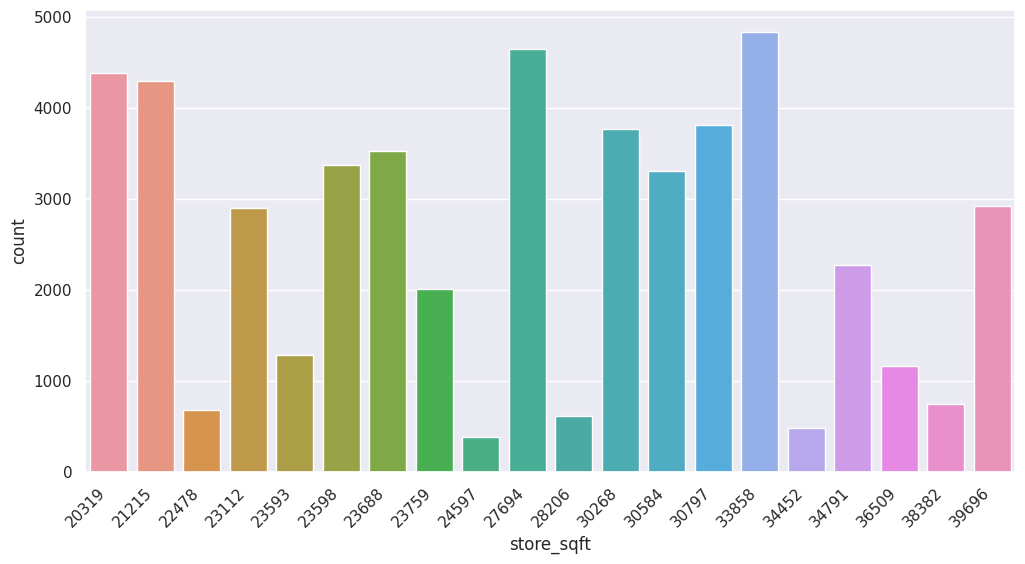

In [50]:
# visualize how the now categorical ft. store_sqft is
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=X['store_sqft'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

After visualizing all the columns in X, we get that they're all categorical. So, when applying Polynomial Ridge Regression, let's use OHE

In [23]:
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [24]:
%%time
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), list(X))], remainder='passthrough'),
                      PolynomialFeatures(4, include_bias=False, interaction_only=True),
                      Ridge())

score_model(model, label='OHE_Poly4_Ridge')

Fold 1: rmse = 0.30180
Fold 2: rmse = 0.29957
Fold 3: rmse = 0.30276
Fold 4: rmse = 0.30279
Fold 5: rmse = 0.30501
Average rmsle: 0.30239
CPU times: user 1h 8min 2s, sys: 5min 33s, total: 1h 13min 35s
Wall time: 1h 11min 1s


## RandomForest

In [26]:
%%time
from sklearn.ensemble import RandomForestRegressor

model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), list(X))], remainder='passthrough'),
                      RandomForestRegressor(
                          bootstrap=False,
                          max_features=20,
                          n_estimators=500,
                          min_weight_fraction_leaf=4.5/360336,
                          random_state=SEED,
                          n_jobs=-1
                      ))

score_model(model, label='OHE_RF')

Fold 1: rmse = 0.30173
Fold 2: rmse = 0.29960
Fold 3: rmse = 0.30262
Fold 4: rmse = 0.30271
Fold 5: rmse = 0.30504
Average rmsle: 0.30234
CPU times: user 18min 17s, sys: 2.92 s, total: 18min 20s
Wall time: 11min 11s


## ExtraTreesRegressor

In [28]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
score_model(ExtraTreesRegressor(
    bootstrap=False,
    max_features=8,
    n_estimators=500,
    min_weight_fraction_leaf=4.5/360336,
    random_state=SEED,
    n_jobs=-1),
                     label='ET')

Fold 1: rmse = 0.30166
Fold 2: rmse = 0.29960
Fold 3: rmse = 0.30262
Fold 4: rmse = 0.30274
Fold 5: rmse = 0.30503
Average rmsle: 0.30233
CPU times: user 1min 44s, sys: 728 ms, total: 1min 45s
Wall time: 1min 7s


## XGBoost

In [81]:
from xgboost import XGBRegressor

xgb_best_params = {
    'eta': 0.09803239047375573,
    'min_child_weight': 1,
    'lambda': 5.296472282923108,
    'alpha': 0.5401269314615912,
    'gamma': 0.035610908484940015,
    'subsample': 0.7855681439189597,
    'colsample_bytree': 0.582868614748634,
    'max_depth': 18,
    'verbose': -1,
    'n_jobs': -1
  }

score_model(XGBRegressor(**xgb_best_params), "XGBoost") # the error about numpy array is after an ann was tried for which conversion was done

AttributeError: ignored

## CatBoost

In [32]:
from catboost import CatBoostRegressor

cb_best_params = {
    'random_seed': SEED,
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    # 'task_type' : 'GPU',
    'bootstrap_type' : 'Bernoulli',
    'verbose' : False,
    'n_estimators' : 1000,
    'max_depth' : 11,
    'learning_rate' : .09373739891212098, # eta
    'min_data_in_leaf' : 1,
    'l2_leaf_reg' : 10, # reg_lambda
    'subsample' : 1 # sample rate for bagging
}

score_model(CatBoostRegressor(**cb_best_params), label="CatBoost")

Fold 1: rmse = 0.30179
Fold 2: rmse = 0.29943
Fold 3: rmse = 0.30260
Fold 4: rmse = 0.30267
Fold 5: rmse = 0.30500
Average rmsle: 0.30230


## LightGBM

In [34]:
%%time
import lightgbm as lgb

lgb_best_params = {
    'learning_rate': 0.1,
    'n_estimators': 450,
    'num_leaves': 100,
    'min_child_samples': 1,
    'min_child_weight': 1e1,
    'categorical_feature': [list(X).index('store_sqft')],
    'random_state': SEED,
    # 'early_stopping_round': 10,
    'objective': 'regression',
    'verbose': -1
}

score_model(lgb.LGBMRegressor(**lgb_best_params), "LightGBM")

Fold 1: rmse = 0.30181
Fold 2: rmse = 0.29947
Fold 3: rmse = 0.30268
Fold 4: rmse = 0.30272
Fold 5: rmse = 0.30497
Average rmsle: 0.30233
CPU times: user 20.9 s, sys: 780 ms, total: 21.7 s
Wall time: 24.1 s


In [ ]:
## To do: ANN

# Evaluation

In [74]:
res_df = pd.DataFrame(result_list, columns=["Label","Model","RMSLE","OOF_preds","Execution_Time"])
res_df.sort_values('RMSLE', inplace=True)

In [88]:
res_df

Label                                              Model  \
4         CatBoost  <catboost.core.CatBoostRegressor object at 0x7...   
2               ET  (ExtraTreeRegressor(max_features=8,\n         ...   
5         LightGBM  LGBMRegressor(categorical_feature=[3], min_chi...   
1           OHE_RF  (ColumnTransformer(remainder='passthrough',\n ...   
0  OHE_Poly4_Ridge  (ColumnTransformer(remainder='passthrough',\n ...   
3          XGBoost  XGBRegressor(alpha=0.5401269314615912, base_sc...   

      RMSLE                                          OOF_preds  \
4  0.302296  [101.5436256473351, 102.82285751563357, 106.84...   
2  0.302331  [101.83675000000042, 102.78903225806428, 106.4...   
5  0.302331  [101.61367591811006, 102.88696801278685, 106.5...   
1  0.302340  [101.83675000000042, 102.78903225806428, 106.4...   
0  0.302387  [101.82438356954131, 103.2702936676142, 106.90...   
3  0.303244  [100.39805603027344, 106.73283386230469, 108.3...   

          Execution_Time  
4 0 days 00:01:31.215047  
2 0 days 00:01:07.826340  
5 0 days 00:00:24.093143  
1 0 days 00:11:11.304631  
0 0 days 01:11:01.227741  
3 0 days 00:00:07.888273

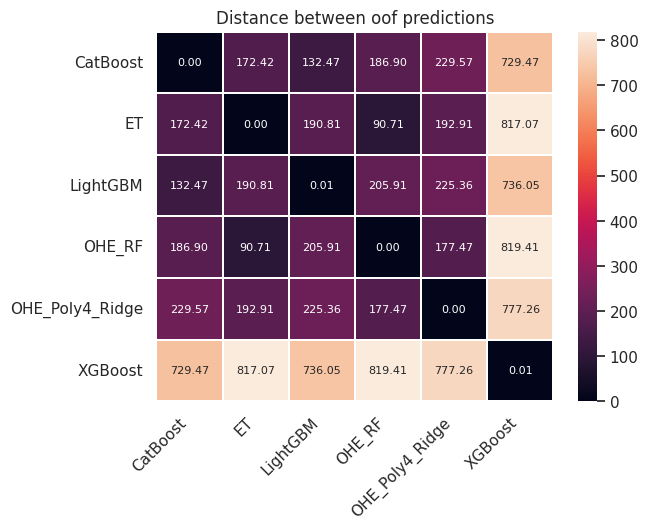

In [92]:
from sklearn.metrics.pairwise import euclidean_distances

# Display the distances between oof predictions
oof = np.column_stack(list(res_df.OOF_preds))
distances = euclidean_distances(oof.T, oof.T)

plt.title('Distance between oof predictions')
sns.heatmap(distances, linewidth=0.1, fmt='.2f', annot=True, annot_kws={'size': 8}, xticklabels=res_df.Label, yticklabels=res_df.Label)
plt.xticks(rotation=45, ha='right')
plt.show()

- The models with maximum distances among them are the ones with best and worst performance.

# Stacking

In [121]:
# Weighted blend (ridge regression)
r = res_df.set_index('Label')
oof = np.column_stack(list(r.OOF_preds))
optimum_blend = Ridge(positive=True, tol=1e-6, alpha=100)
optimum_blend.fit(oof, y.values)
optimum_oof = optimum_blend.predict(oof)
trmsle = rmsle_custom(y.values, optimum_oof)
print(f'Ridge regression blend training rmse: {trmsle:.5f}')
display(pd.Series(optimum_blend.coef_.round(2), r.index, name='weight'))
# result_list.append((f"Optimum blend", None, None, trmsle, optimum_oof, datetime.timedelta()))

Ridge regression blend training rmse: 0.30224


Label
CatBoost           0.00
ET                 0.39
LightGBM           0.00
OHE_RF             0.36
OHE_Poly4_Ridge    0.00
XGBoost            0.14
Name: weight, dtype: float64

In [126]:
labels = res_df['Label']
oof_preds = res_df['OOF_preds']
weights = pd.Series(optimum_blend.coef_.round(2), index=labels, name='weight')

oof_matrix = np.column_stack(oof_preds)
weighted_oof = oof_matrix.dot(weights)
X_train, X_test, y_train, y_test = train_test_split(weighted_oof, y.values, test_size=0.2, random_state=SEED)

# Train a final model using Ridge regression as an example
X_train_reshaped = X_train.reshape(-1, 1)
final_model = Ridge()
final_model.fit(X_train_reshaped, y_train)

Ridge()

In [125]:
weighted_oof.shape

(51363,)

In [ ]:
## for deployment we create the whole pipeline with fe, ft. dropping. adding trained models and then prediction
## this is not an end to end project, it was just a quick trial of stacking